In [ ]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import optuna

In [ ]:
# Read data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [ ]:
# Check shape
train.shape

(74051, 10)

In [ ]:
# Data info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


There are 74051 enteries with 10 columns. the data set has no null values

In [ ]:
# See first 5 rows
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [ ]:
# Drop id column as it is un-informative
train.drop(columns='id',axis=1,inplace=True)
test.drop(columns='id',axis=1,inplace=True)

# Replace whitespaces in column names with underscore
train.columns=train.columns.str.replace(' ','_')
test.columns=test.columns.str.replace(' ','_')

In [ ]:
# Check duplicates
train.duplicated().sum()

0

There are no duplicates in this data and from observing the dataframe, only the sex column is categorical. Age is our target variable

In [ ]:
# Change sex column to category type
train.Sex=train.Sex.astype('category')

# Check sex column to see its values
train.Sex.value_counts()

M    27084
I    23957
F    23010
Name: Sex, dtype: int64

There are 3 categories under the sex columns

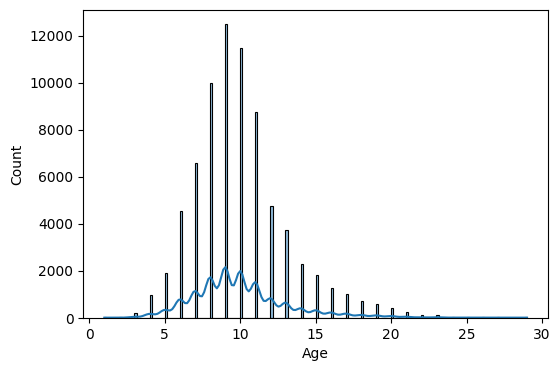

In [ ]:
# Check distribution of target column
plt.figure(figsize=(6,4),)
sns.histplot(x=train['Age'],kde=True,edgecolor='black',linewidth=0.8)
plt.show()

In [ ]:
# Check the distribution of numeric columns
train.describe()

,Length,Diameter,Height,Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


Some obsersations have 0 height, they will be replaced with lowest value in the column

In [ ]:
# Replace zero heights with median value
train['Height']=train['Height'].replace(0,(train['Height'].median()))

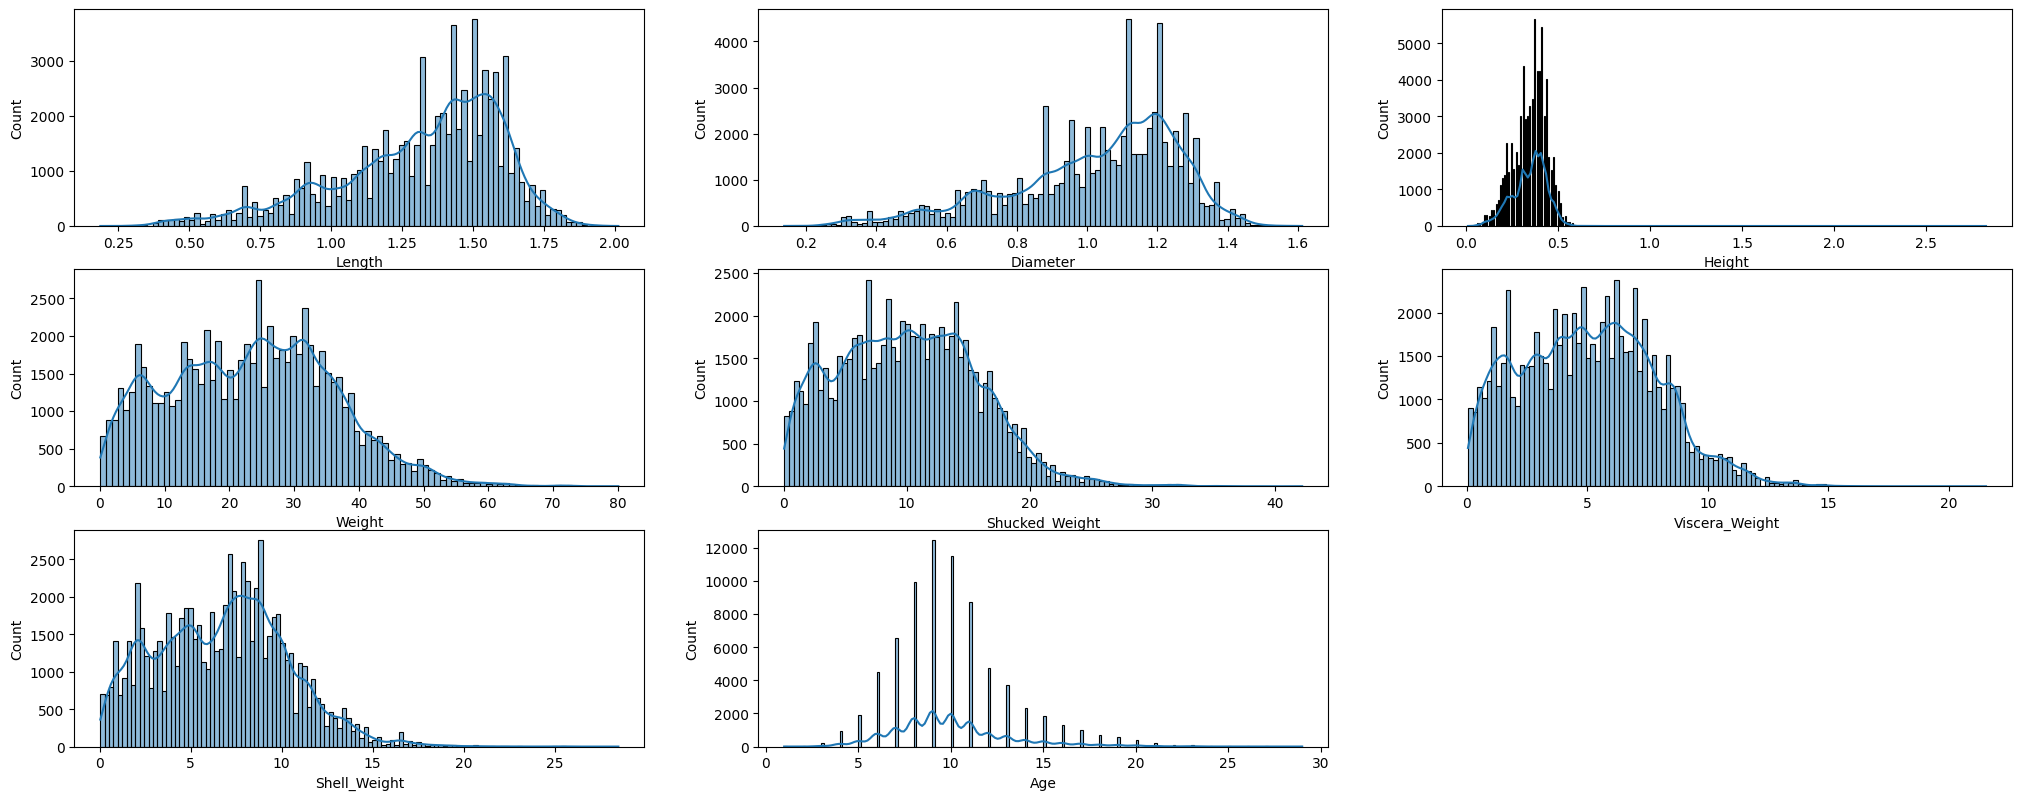

In [ ]:

# Check distribution of features
num_data=train.select_dtypes(include='number')
plt.figure(figsize=(25,40), facecolor='white')
plotnumber =1
for col in num_data.columns:
      ax = plt.subplot(12,3,plotnumber)
      sns.histplot(x=train[col],kde=True,edgecolor='black',linewidth=0.8)
      plt.ticklabel_format(style='plain',axis='x')
      plt.xlabel(col)
      plotnumber+=1
plt.show()

In [ ]:
# Check skew
train.skew(numeric_only=True)

Length           -0.844377
Diameter         -0.812866
Height            0.101003
Weight            0.231465
Shucked_Weight    0.349472
Viscera_Weight    0.286383
Shell_Weight      0.277459
Age               1.092919
dtype: float64

Length and Diameter and Age are morre skewwed compared to the rest. this will be handled later on.

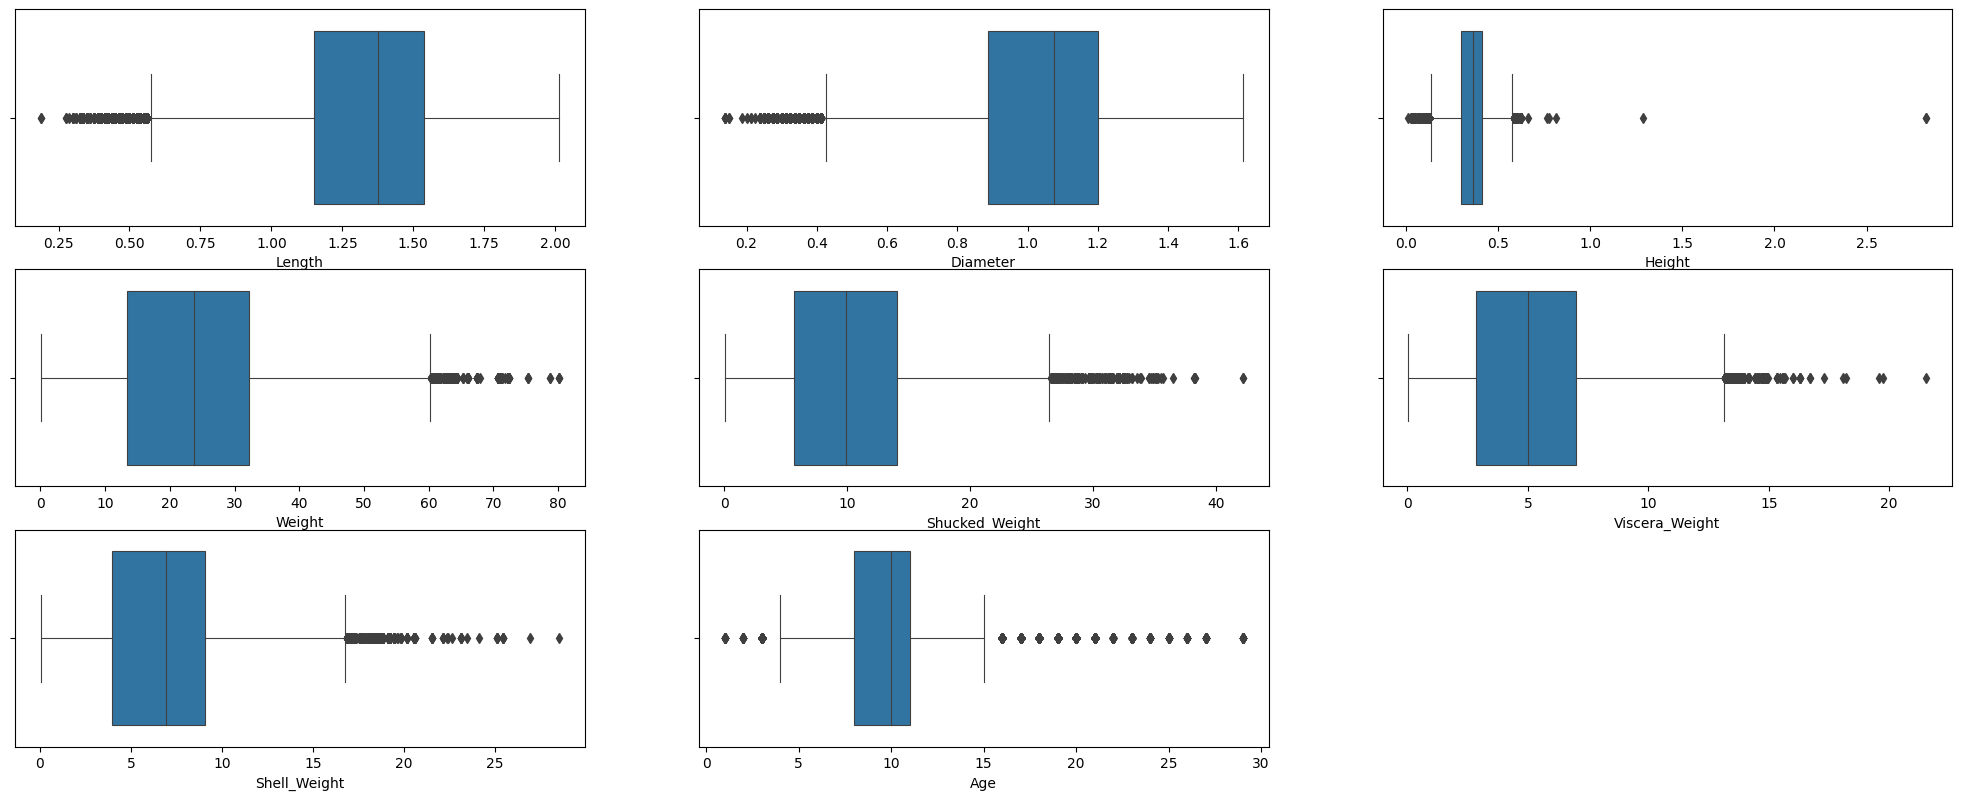

In [ ]:
# Using boxplot to see proportion of outliers
plt.figure(figsize=(25,40), facecolor='white')
plotnumber =1
for col in num_data.columns:
      ax = plt.subplot(12,3,plotnumber)
      sns.boxplot(x=train[col],linewidth=0.8)
      plt.ticklabel_format(style='plain',axis='x')
      plt.xlabel(col)
      plotnumber+=1
plt.show()

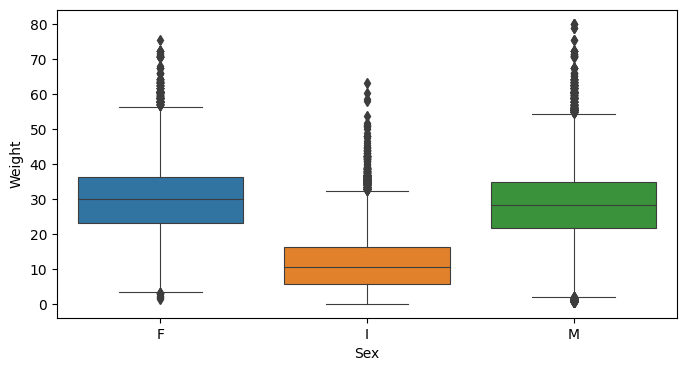

In [ ]:
# Are male crabs heavier than female crabs
plt.figure(figsize=(8,4))
sns.boxplot(data=train,y='Weight',x='Sex',linewidth=0.8)
plt.show()

on average, female crabs are slightly higher weight

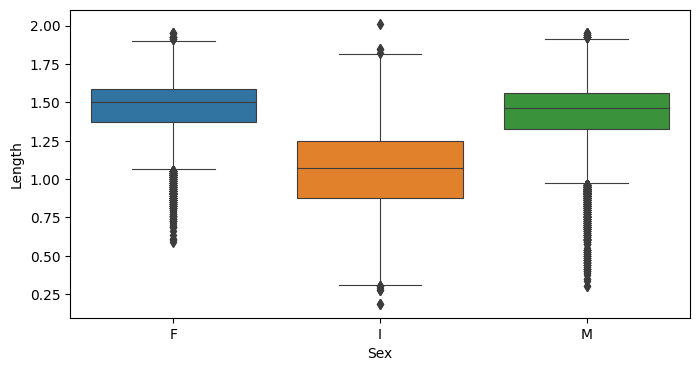

In [ ]:
# Crab with more length
plt.figure(figsize=(8,4))
sns.boxplot(data=train,y='Length',x='Sex',linewidth=0.8)
plt.show()

female have slightly higher length than males, crabs with I -sex hae lower length on average

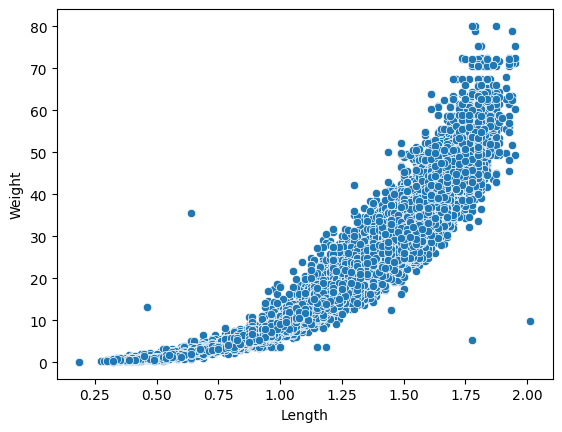

In [ ]:
# Relationship between weight and height
sns.scatterplot(data=train,x='Length',y='Weight')
plt.show()

There is a strong relationship between weight and length, even though its not linear, its a strong positive relationship

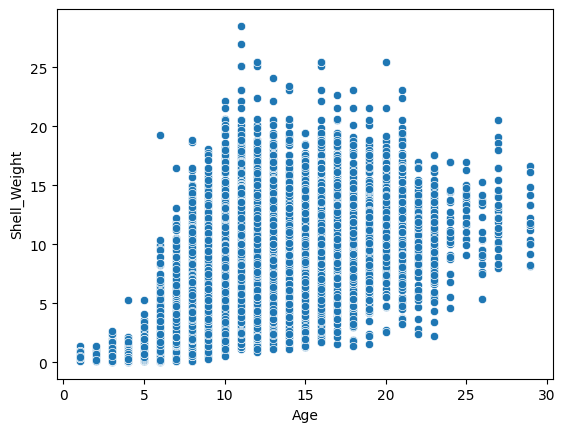

In [ ]:
# Relationship between shell weight and age
sns.scatterplot(data=train,x='Age',y='Shell_Weight')
plt.show()

There is a strong correlation between shell weight and Age. As Age increases , shell weight increases.

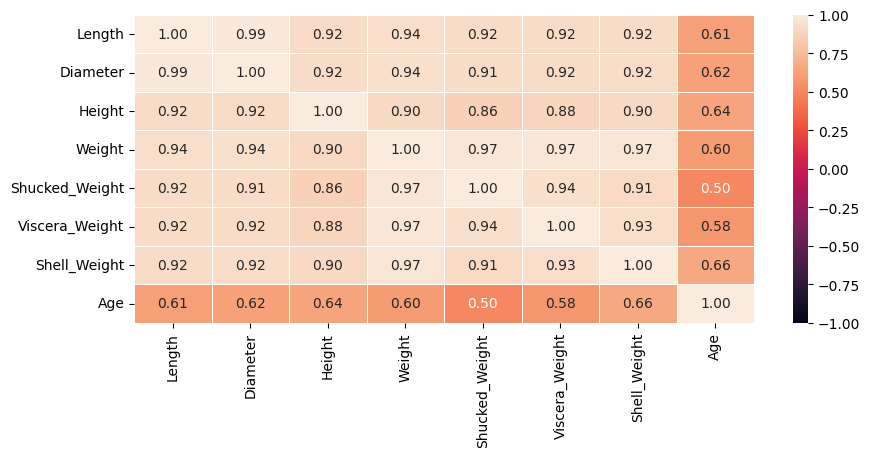

In [ ]:
# Compute the correlation matrix
corr_matrix = num_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10,4))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1,fmt='.2f',linewidth=0.7)
plt.show()

As expeted, all the variables are strongly correlated. since, we are concerned with prediction and not inference, multicolinearity is not much of an issue here.

In [ ]:
# Separate features and target in train and test set
X_train=train.drop('Age',axis=1)
y_train=train['Age']

In [ ]:
# Set callback for early stopping
es_callback=[lgb.early_stopping(5)]

In [ ]:
# Modelling
kf = KFold(n_splits=10)
model=lgb.LGBMRegressor(objective = 'mae', force_row_wise=True, n_estimators=150,importance_type="gain",
                        random_state=12, n_jobs=-1, verbose=-1)

# Get validation mae
valid_mae=[]
feature_importance = np.zeros(X_train.shape[1])

for train_idx, valid_idx in kf.split(X_train):
     X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
     y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]
     model = model.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold),callbacks=es_callback)
     y_pred=model.predict(X_valid_fold)
     mae=mean_absolute_error(y_valid_fold,y_pred)
     valid_mae.append(mae)
     # Accumulate feature importance
     feature_importance += model.feature_importances_

print('-----------------------------------------------------')
print(f'\nMean validation MAE on 10 folds = {np.mean(valid_mae):.3f}')

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 1.35544
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 1.35532
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[110]	valid_0's l1: 1.36047
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's l1: 1.38667
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[86]	valid_0's l1: 1.36751
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[121]	valid_0's l1: 1.34281
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's l1: 1.3593
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 1.4185
Training

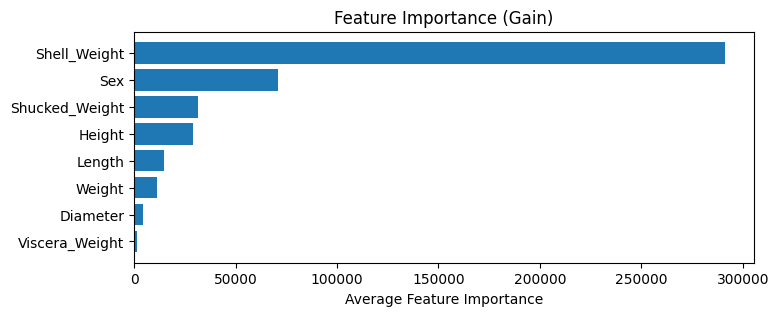

In [ ]:
# Plot feature importance
avg_feature_importance = feature_importance / kf.get_n_splits()
feature_names = X_train.columns

# Create a dataframe for better visualization (optional)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': avg_feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plotting
plt.figure(figsize=(8, 3))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Average Feature Importance')
plt.title('Feature Importance (Gain)')
plt.show()

#### hyperparameter optimization

In [ ]:
# Define objective
def objective(trial):
      params = {
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-6, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-6, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float("learning_rate", 0.0001, 0.3, log=True),
        'max_bin': trial.suggest_int("max_bin", 128, 512, 32),
        'n_estimators': trial.suggest_int("n_estimators", 100, 500, 25)
        }

      pruning_callback = optuna.integration.LightGBMPruningCallback(trial,'l1')
\
      model = lgb.LGBMRegressor(objective = 'mae',force_row_wise=True,**params,callbacks=[pruning_callback],verbose=-1)
      trial_mae=[]
      for train_idx, valid_idx in kf.split(X_train):
          X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
          y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]
          model = model.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold),callbacks=es_callback,)
          y_pred=model.predict(X_valid_fold)
          mae=mean_absolute_error(y_valid_fold,y_pred)
          trial_mae.append(mae)
      return np.mean(trial_mae)

In [ ]:
# Create study
sampler = optuna.samplers.TPESampler()
pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=400, reduction_factor=3)

study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner,study_name="LGBM Regressor")
study.optimize(objective, n_trials=150, gc_after_trial=True, n_jobs=-1)

[I 2023-11-25 12:27:32,187] A new study created in memory with name: LGBM Regressor


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[152]	valid_0's l1: 1.37075
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[263]	valid_0's l1: 1.35718
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.05041
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[191]	valid_0's l1: 1.36422
Early stopping, best iteration is:
[198]	valid_0's l1: 1.36403
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.07188
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[191]	valid_0's l1: 1.37417
Early stopping, best iteration is:
[242]	val

[I 2023-11-25 12:27:48,170] Trial 0 finished with value: 2.1629462564260296 and parameters: {'lambda_l1': 0.0002488602010159007, 'lambda_l2': 0.0037418089436320567, 'num_leaves': 202, 'max_depth': 3, 'colsample_bytree': 0.8202677729328259, 'feature_fraction': 0.7123693217756457, 'bagging_fraction': 0.981382493533686, 'bagging_freq': 6, 'min_child_samples': 40, 'learning_rate': 0.003962028948651024, 'max_bin': 480, 'n_estimators': 100}. Best is trial 0 with value: 2.1629462564260296.


Did not meet early stopping. Best iteration is:
[184]	valid_0's l1: 1.35491
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[296]	valid_0's l1: 1.34553
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 1.73132
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[158]	valid_0's l1: 1.36692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 1.71048
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[204]	valid_0's l1: 1.42478
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	valid_0's l1: 1.63871
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[138]	valid_0's l1: 1.37106
Training until validation scores don't improve for 5 rounds
Early sto

[I 2023-11-25 12:27:56,666] Trial 1 finished with value: 1.3756046880476778 and parameters: {'lambda_l1': 4.563491758998775, 'lambda_l2': 0.000839083689988297, 'num_leaves': 253, 'max_depth': 3, 'colsample_bytree': 0.7393977427861097, 'feature_fraction': 0.797338039570332, 'bagging_fraction': 0.767736792249951, 'bagging_freq': 1, 'min_child_samples': 25, 'learning_rate': 0.14390630773898766, 'max_bin': 448, 'n_estimators': 475}. Best is trial 1 with value: 1.3756046880476778.


Early stopping, best iteration is:
[206]	valid_0's l1: 1.39525
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[131]	valid_0's l1: 1.42964
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[225]	valid_0's l1: 1.36826
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.81455
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[128]	valid_0's l1: 1.40713
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[225]	valid_0's l1: 1.3392
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.89043
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 1.47219
Training until validation scores don't improve for 5 

[I 2023-11-25 12:28:40,631] Trial 3 finished with value: 2.1120232895650597 and parameters: {'lambda_l1': 0.0022753627934637135, 'lambda_l2': 2.5681760559906914, 'num_leaves': 49, 'max_depth': 9, 'colsample_bytree': 0.2049875062833028, 'feature_fraction': 0.651004744867817, 'bagging_fraction': 0.681944291561084, 'bagging_freq': 6, 'min_child_samples': 95, 'learning_rate': 0.002271754010449943, 'max_bin': 384, 'n_estimators': 350}. Best is trial 1 with value: 1.3756046880476778.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[225]	valid_0's l1: 1.3555
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.24278
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 1.77762
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[157]	valid_0's l1: 1.41226
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[225]	valid_0's l1: 1.38395


[I 2023-11-25 12:28:57,105] Trial 2 finished with value: 1.705024886783826 and parameters: {'lambda_l1': 0.0006710025935623365, 'lambda_l2': 0.0005021271872670785, 'num_leaves': 189, 'max_depth': 14, 'colsample_bytree': 0.9540384745035889, 'feature_fraction': 0.6995410275259341, 'bagging_fraction': 0.9265728335833394, 'bagging_freq': 6, 'min_child_samples': 39, 'learning_rate': 0.014154755942941825, 'max_bin': 288, 'n_estimators': 225}. Best is trial 1 with value: 1.3756046880476778.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 1.77307
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.35177
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 1.63346
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.35556
Early stopping, best iteration is:
[21]	valid_0's l1: 1.35556
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 1.36154
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 2.03894
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.38279
Training until validation s

[I 2023-11-25 12:29:04,848] Trial 4 finished with value: 2.31641320763807 and parameters: {'lambda_l1': 0.0026574166747607817, 'lambda_l2': 0.00258985860169612, 'num_leaves': 250, 'max_depth': 7, 'colsample_bytree': 0.3527541928412027, 'feature_fraction': 0.6854675414427716, 'bagging_fraction': 0.5304896826464729, 'bagging_freq': 7, 'min_child_samples': 17, 'learning_rate': 0.00030920701051907946, 'max_bin': 512, 'n_estimators': 300}. Best is trial 1 with value: 1.3756046880476778.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 1.99664
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 1.35449
Early stopping, best iteration is:
[35]	valid_0's l1: 1.35449
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.41471
Early stopping, best iteration is:
[19]	valid_0's l1: 1.41471
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.35746
Early stopping, best iteration is:
[16]	valid_0's l1: 1.35746
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:29:08,093] Trial 5 finished with value: 1.3666979767413754 and parameters: {'lambda_l1': 1.016641890135351e-06, 'lambda_l2': 0.9376542230603138, 'num_leaves': 91, 'max_depth': 12, 'colsample_bytree': 0.4442266349115609, 'feature_fraction': 0.6132385421555382, 'bagging_fraction': 0.529936970523757, 'bagging_freq': 1, 'min_child_samples': 100, 'learning_rate': 0.26349812798334543, 'max_bin': 480, 'n_estimators': 400}. Best is trial 5 with value: 1.3666979767413754.


Early stopping, best iteration is:
[31]	valid_0's l1: 1.38128
Early stopping, best iteration is:
[31]	valid_0's l1: 1.38128
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 2.15186
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	valid_0's l1: 1.35489
Early stopping, best iteration is:
[61]	valid_0's l1: 1.35489
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 1.35342
Early stopping, best iteration is:
[57]	valid_0's l1: 1.35342
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	valid_0's l1: 1.35742
Early stopping, best iteration is:
[52]	valid_0's l1: 1.35742
Training until validati

[I 2023-11-25 12:29:17,265] Trial 6 finished with value: 2.308082312367628 and parameters: {'lambda_l1': 1.165759110709066e-05, 'lambda_l2': 1.0003823840458888, 'num_leaves': 65, 'max_depth': 6, 'colsample_bytree': 0.6357938452262298, 'feature_fraction': 0.6470561422230643, 'bagging_fraction': 0.5153209438498412, 'bagging_freq': 1, 'min_child_samples': 46, 'learning_rate': 0.00045268282541396004, 'max_bin': 352, 'n_estimators': 475}. Best is trial 5 with value: 1.3666979767413754.


Training until validation scores don't improve for 5 roundsEarly stopping, best iteration is:
[48]	valid_0's l1: 1.3609

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[62]	valid_0's l1: 1.33418
Early stopping, best iteration is:
[62]	valid_0's l1: 1.33418
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 1.35581
Early stopping, best iteration is:
[64]	valid_0's l1: 1.35581
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.40763
Early stopping, best iteration is:
[45]	valid_0's l1: 1.40763
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 1.34514
Early stopping, best iter

[I 2023-11-25 12:29:24,912] Trial 7 finished with value: 1.36370563427838 and parameters: {'lambda_l1': 1.267237000475896e-06, 'lambda_l2': 6.400540501715374, 'num_leaves': 45, 'max_depth': 13, 'colsample_bytree': 0.8371455728708675, 'feature_fraction': 0.7970449654072294, 'bagging_fraction': 0.4300305803204782, 'bagging_freq': 5, 'min_child_samples': 67, 'learning_rate': 0.14322319934135633, 'max_bin': 224, 'n_estimators': 275}. Best is trial 7 with value: 1.36370563427838.


Early stopping, best iteration is:
[56]	valid_0's l1: 1.38338
Early stopping, best iteration is:
[56]	valid_0's l1: 1.38338
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 1.6672
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.37243
Early stopping, best iteration is:
[100]	valid_0's l1: 1.37243
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.8047
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.36861
Early stopping, best iteration is:
[100]	valid_0's l1: 1.36861
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rou

[I 2023-11-25 12:29:33,026] Trial 8 finished with value: 2.017164113669044 and parameters: {'lambda_l1': 1.4170970161037543e-05, 'lambda_l2': 0.3643924613407578, 'num_leaves': 25, 'max_depth': 10, 'colsample_bytree': 0.4959953628782148, 'feature_fraction': 0.6123920068454389, 'bagging_fraction': 0.6755328774780771, 'bagging_freq': 5, 'min_child_samples': 6, 'learning_rate': 0.006264291436937259, 'max_bin': 192, 'n_estimators': 150}. Best is trial 7 with value: 1.36370563427838.


Early stopping, best iteration is:
[18]	valid_0's l1: 1.85286
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.3765
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 1.65578
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.39853
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.65359
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.37786
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.67678
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.35362
Training until validation sco

[I 2023-11-25 12:29:59,637] Trial 9 finished with value: 1.3808612561352536 and parameters: {'lambda_l1': 0.12015238971725968, 'lambda_l2': 2.916848559198121e-06, 'num_leaves': 139, 'max_depth': 11, 'colsample_bytree': 0.30787633787474156, 'feature_fraction': 0.6025731613056584, 'bagging_fraction': 0.4531774651427583, 'bagging_freq': 2, 'min_child_samples': 70, 'learning_rate': 0.029794236814662107, 'max_bin': 352, 'n_estimators': 100}. Best is trial 7 with value: 1.36370563427838.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.75647
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[225]	valid_0's l1: 1.41994
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 1.85286
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[225]	valid_0's l1: 1.43007


[I 2023-11-25 12:30:03,517] Trial 10 finished with value: 2.0945743431131136 and parameters: {'lambda_l1': 1.2884184804653669e-05, 'lambda_l2': 0.006857099117092406, 'num_leaves': 233, 'max_depth': 14, 'colsample_bytree': 0.658389184418468, 'feature_fraction': 0.40086003421608357, 'bagging_fraction': 0.7074164668343979, 'bagging_freq': 6, 'min_child_samples': 25, 'learning_rate': 0.00977479083101178, 'max_bin': 128, 'n_estimators': 200}. Best is trial 7 with value: 1.36370563427838.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	valid_0's l1: 1.86543
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	valid_0's l1: 1.54362
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.36185
Early stopping, best iteration is:
[26]	valid_0's l1: 1.36185
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 2.0031
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 1.36372
Early stopping, best iteration is:
[33]	valid_0's l1: 1.363
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 1.65732
Early stopping, best iteration

[I 2023-11-25 12:30:10,267] Trial 11 finished with value: 1.8895152852180543 and parameters: {'lambda_l1': 1.0308197721067802e-06, 'lambda_l2': 9.625535048430168, 'num_leaves': 3, 'max_depth': 15, 'colsample_bytree': 0.9717614443245259, 'feature_fraction': 0.9973411975726796, 'bagging_fraction': 0.400355322824064, 'bagging_freq': 3, 'min_child_samples': 73, 'learning_rate': 0.05221116849470665, 'max_bin': 128, 'n_estimators': 225}. Best is trial 7 with value: 1.36370563427838.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 1.63981
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.36726
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.36225
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.34094
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.35808
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.36203
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.35929
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.41397
Training until validation

[I 2023-11-25 12:30:16,112] Trial 12 finished with value: 1.3708122664384699 and parameters: {'lambda_l1': 5.168792273721938e-06, 'lambda_l2': 9.741666605157397, 'num_leaves': 99, 'max_depth': 12, 'colsample_bytree': 0.4455972225465817, 'feature_fraction': 0.9852206622597873, 'bagging_fraction': 0.40414579213838214, 'bagging_freq': 3, 'min_child_samples': 100, 'learning_rate': 0.27855777825336653, 'max_bin': 256, 'n_estimators': 375}. Best is trial 7 with value: 1.36370563427838.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.38783
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.34565
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 1.36402
Early stopping, best iteration is:
[17]	valid_0's l1: 1.36089
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 1.45245
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.41266
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 1.36997
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 1.35311
Training until validation

[I 2023-11-25 12:30:21,849] Trial 13 finished with value: 1.3722112133065174 and parameters: {'lambda_l1': 1.4349975907384232e-06, 'lambda_l2': 0.15486214718729957, 'num_leaves': 96, 'max_depth': 12, 'colsample_bytree': 0.517003114197729, 'feature_fraction': 0.834479794151577, 'bagging_fraction': 0.5192478660688267, 'bagging_freq': 4, 'min_child_samples': 77, 'learning_rate': 0.2869895652007425, 'max_bin': 256, 'n_estimators': 375}. Best is trial 7 with value: 1.36370563427838.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	valid_0's l1: 1.35936
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.35842
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 1.33233
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 1.36297
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	valid_0's l1: 1.35096
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 1.37058
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.4007
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.39259
Training until validation

[I 2023-11-25 12:30:37,303] Trial 14 finished with value: 1.4395118708411716 and parameters: {'lambda_l1': 1.5084125447981458e-06, 'lambda_l2': 0.6488985077888612, 'num_leaves': 108, 'max_depth': 12, 'colsample_bytree': 0.530957460604286, 'feature_fraction': 0.8245277553320614, 'bagging_fraction': 0.5476474625447221, 'bagging_freq': 4, 'min_child_samples': 79, 'learning_rate': 0.09513985235091639, 'max_bin': 224, 'n_estimators': 400}. Best is trial 7 with value: 1.36370563427838.


Early stopping, best iteration is:
[37]	valid_0's l1: 1.37012
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 1.34519
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[171]	valid_0's l1: 1.35543
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 1.35958
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[118]	valid_0's l1: 1.36332
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 1.40984
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.36733
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 1.35096
Training until validation scores don't improve for 5 rounds
Early stopping, best

[I 2023-11-25 12:30:52,555] Trial 15 finished with value: 1.389064706326319 and parameters: {'lambda_l1': 8.777944907791736e-05, 'lambda_l2': 0.13191803242602357, 'num_leaves': 138, 'max_depth': 13, 'colsample_bytree': 0.6120774505453739, 'feature_fraction': 0.5165603942208856, 'bagging_fraction': 0.5747866537548844, 'bagging_freq': 4, 'min_child_samples': 58, 'learning_rate': 0.09131418751976313, 'max_bin': 192, 'n_estimators': 300}. Best is trial 7 with value: 1.36370563427838.


Early stopping, best iteration is:
[48]	valid_0's l1: 1.39887
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[118]	valid_0's l1: 1.37121
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.40059
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[137]	valid_0's l1: 1.34347
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 1.36127
Early stopping, best iteration is:
[107]	valid_0's l1: 1.36085
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 2.07281
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[105]	valid_0's l1: 1.41771
Early stopping, best iteration is:
[105]	valid_0's l1: 1.41771
Training until va

[I 2023-11-25 12:31:10,901] Trial 16 finished with value: 1.3765896762633798 and parameters: {'lambda_l1': 4.875884423126256e-05, 'lambda_l2': 0.09331947226028835, 'num_leaves': 61, 'max_depth': 8, 'colsample_bytree': 0.8024225238751223, 'feature_fraction': 0.5362814233520675, 'bagging_fraction': 0.585964547500046, 'bagging_freq': 2, 'min_child_samples': 59, 'learning_rate': 0.06696471035618302, 'max_bin': 192, 'n_estimators': 300}. Best is trial 7 with value: 1.36370563427838.


Early stopping, best iteration is:
[119]	valid_0's l1: 1.39731
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[348]	valid_0's l1: 1.3402
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[316]	valid_0's l1: 1.34752
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[116]	valid_0's l1: 1.37464
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[289]	valid_0's l1: 1.35008
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[89]	valid_0's l1: 1.41368
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[327]	valid_0's l1: 1.35536
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[355]	valid_0's l1: 1.35085
Training until validation scores don't improve for 5 rounds
Early stopping, be

[I 2023-11-25 12:31:43,497] Trial 17 finished with value: 1.512071187728786 and parameters: {'lambda_l1': 0.00018420012050929252, 'lambda_l2': 0.03172252234118792, 'num_leaves': 57, 'max_depth': 9, 'colsample_bytree': 0.1280191284286108, 'feature_fraction': 0.5367675972551007, 'bagging_fraction': 0.44970394645521655, 'bagging_freq': 2, 'min_child_samples': 89, 'learning_rate': 0.026136800862662977, 'max_bin': 416, 'n_estimators': 425}. Best is trial 7 with value: 1.36370563427838.


Early stopping, best iteration is:
[109]	valid_0's l1: 1.3884
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.36699
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.35666
Early stopping, best iteration is:
[36]	valid_0's l1: 1.35666
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 1.35849
Early stopping, best iteration is:
[32]	valid_0's l1: 1.35849
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 1.92801
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 1.35824
Early stopping, best iteration is:
[31]	valid_0's l1: 1.35824
Training until validati

[I 2023-11-25 12:31:48,675] Trial 18 finished with value: 1.6919446472894595 and parameters: {'lambda_l1': 5.475634877438119e-05, 'lambda_l2': 2.501032242405384, 'num_leaves': 35, 'max_depth': 15, 'colsample_bytree': 0.10187399155416871, 'feature_fraction': 0.7878172665853678, 'bagging_fraction': 0.4775321564894015, 'bagging_freq': 5, 'min_child_samples': 86, 'learning_rate': 0.025519203616253483, 'max_bin': 416, 'n_estimators': 425}. Best is trial 7 with value: 1.36370563427838.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 1.37829
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	valid_0's l1: 1.3564
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.36843
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.35086
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	valid_0's l1: 1.34484
Early stopping, best iteration is:
[46]	valid_0's l1: 1.34484
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 1.36007
Early stopping, best iteration is:
[32]	valid_0's l1: 1.36007
Training until validation scores don't improve for 5 rounds
Training until validation

[I 2023-11-25 12:32:01,381] Trial 19 finished with value: 1.3758065295564763 and parameters: {'lambda_l1': 3.868485847212471e-05, 'lambda_l2': 2.115168840044326, 'num_leaves': 160, 'max_depth': 15, 'colsample_bytree': 0.3611295875977932, 'feature_fraction': 0.7750185570780013, 'bagging_fraction': 0.4811925479174213, 'bagging_freq': 5, 'min_child_samples': 87, 'learning_rate': 0.18636650299086271, 'max_bin': 320, 'n_estimators': 500}. Best is trial 7 with value: 1.36370563427838.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 1.35362
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 1.35215
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.40817
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.35034
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.34318
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 1.35463
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:32:06,974] Trial 20 finished with value: 1.3645087106207827 and parameters: {'lambda_l1': 4.1494089663231695e-06, 'lambda_l2': 1.2317190861850886, 'num_leaves': 161, 'max_depth': 11, 'colsample_bytree': 0.4122310053632257, 'feature_fraction': 0.9048553487730265, 'bagging_fraction': 0.6104068232229729, 'bagging_freq': 5, 'min_child_samples': 62, 'learning_rate': 0.19541521642379434, 'max_bin': 320, 'n_estimators': 325}. Best is trial 7 with value: 1.36370563427838.


Early stopping, best iteration is:
[26]	valid_0's l1: 1.38205
Early stopping, best iteration is:
[26]	valid_0's l1: 1.38205
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	valid_0's l1: 1.35314
Early stopping, best iteration is:
[65]	valid_0's l1: 1.35314
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.35661
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.33642
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 1.35307
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	valid_0's l1: 1.35332
Training until validation scores don't improve for 5 rounds
Early stopping, best ite

[I 2023-11-25 12:32:20,405] Trial 21 finished with value: 1.3654118364190566 and parameters: {'lambda_l1': 4.227140654862676e-06, 'lambda_l2': 8.310412733322606, 'num_leaves': 85, 'max_depth': 11, 'colsample_bytree': 0.8952574812256494, 'feature_fraction': 0.917252352719371, 'bagging_fraction': 0.40837695690180675, 'bagging_freq': 3, 'min_child_samples': 66, 'learning_rate': 0.1298786572976991, 'max_bin': 288, 'n_estimators': 325}. Best is trial 7 with value: 1.36370563427838.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.3531
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[33]	valid_0's l1: 1.35773
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.39624
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.35391
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.34457
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 1.35724
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:32:27,686] Trial 22 finished with value: 1.3648636793759963 and parameters: {'lambda_l1': 3.5256783041091767e-06, 'lambda_l2': 8.110962038801231, 'num_leaves': 84, 'max_depth': 11, 'colsample_bytree': 0.45561730681834467, 'feature_fraction': 0.8836241931872606, 'bagging_fraction': 0.6065282966514502, 'bagging_freq': 5, 'min_child_samples': 63, 'learning_rate': 0.1581759235534307, 'max_bin': 320, 'n_estimators': 250}. Best is trial 7 with value: 1.36370563427838.


Early stopping, best iteration is:
[48]	valid_0's l1: 1.37381
Early stopping, best iteration is:
[48]	valid_0's l1: 1.37381
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 1.74326
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 1.3621
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.36532
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.341
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.44379
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 1.35698
Training until validation scores don't improve for 5 rounds
Early stopping, best iterati

[I 2023-11-25 12:32:41,293] Trial 23 finished with value: 1.3656813917220676 and parameters: {'lambda_l1': 3.822638944049374e-06, 'lambda_l2': 6.309264431089548, 'num_leaves': 162, 'max_depth': 10, 'colsample_bytree': 0.8911940675430232, 'feature_fraction': 0.9001653525764525, 'bagging_fraction': 0.4019449276862938, 'bagging_freq': 3, 'min_child_samples': 63, 'learning_rate': 0.12667709100262942, 'max_bin': 288, 'n_estimators': 250}. Best is trial 7 with value: 1.36370563427838.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.34952
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[130]	valid_0's l1: 1.3472
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.40699
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[94]	valid_0's l1: 1.34689
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[136]	valid_0's l1: 1.34228
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 1.34523
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 1.37522


[I 2023-11-25 12:32:58,128] Trial 24 finished with value: 1.5609804406463537 and parameters: {'lambda_l1': 5.016775048578688e-06, 'lambda_l2': 2.7449938399959533, 'num_leaves': 162, 'max_depth': 10, 'colsample_bytree': 0.5965767226950882, 'feature_fraction': 0.8863331731710058, 'bagging_fraction': 0.6112749014263017, 'bagging_freq': 5, 'min_child_samples': 52, 'learning_rate': 0.053134151479806366, 'max_bin': 320, 'n_estimators': 250}. Best is trial 7 with value: 1.36370563427838.


Early stopping, best iteration is:
[105]	valid_0's l1: 1.37419
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 1.34862
Early stopping, best iteration is:
[101]	valid_0's l1: 1.34862
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	valid_0's l1: 1.34692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[105]	valid_0's l1: 1.331
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 1.34802
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 1.34984
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 1.3713
Training until valida

[I 2023-11-25 12:33:23,527] Trial 25 finished with value: 1.3693974358443746 and parameters: {'lambda_l1': 1.3612703910267046e-05, 'lambda_l2': 1.9531197812367327, 'num_leaves': 119, 'max_depth': 13, 'colsample_bytree': 0.5837089500001134, 'feature_fraction': 0.8700181879229038, 'bagging_fraction': 0.6193995593648284, 'bagging_freq': 7, 'min_child_samples': 49, 'learning_rate': 0.05162089050783484, 'max_bin': 352, 'n_estimators': 250}. Best is trial 7 with value: 1.36370563427838.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[77]	valid_0's l1: 1.35012
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 1.35217
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 1.47799
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.34922
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 1.34085
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 1.35925
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:33:31,961] Trial 26 finished with value: 1.4178009620374274 and parameters: {'lambda_l1': 2.167468216827347e-05, 'lambda_l2': 1.4449291891173155, 'num_leaves': 115, 'max_depth': 13, 'colsample_bytree': 0.7030722526690215, 'feature_fraction': 0.8600384971596479, 'bagging_fraction': 0.634592927028361, 'bagging_freq': 7, 'min_child_samples': 50, 'learning_rate': 0.06205512597375813, 'max_bin': 352, 'n_estimators': 275}. Best is trial 7 with value: 1.36370563427838.


Early stopping, best iteration is:
[23]	valid_0's l1: 1.38451
Early stopping, best iteration is:
[33]	valid_0's l1: 1.37711
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 1.35217
Early stopping, best iteration is:
[43]	valid_0's l1: 1.35217
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.35724
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.3334
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 1.35341
Early stopping, best iteration is:
[42]	valid_0's l1: 1.35131
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iter

[I 2023-11-25 12:33:44,681] Trial 27 finished with value: 1.3618682585352442 and parameters: {'lambda_l1': 2.506841385262381e-05, 'lambda_l2': 0.3898078447780315, 'num_leaves': 77, 'max_depth': 13, 'colsample_bytree': 0.701193339237257, 'feature_fraction': 0.9353368610594361, 'bagging_fraction': 0.6376179237872396, 'bagging_freq': 4, 'min_child_samples': 60, 'learning_rate': 0.165836080582681, 'max_bin': 224, 'n_estimators': 175}. Best is trial 27 with value: 1.3618682585352442.


Early stopping, best iteration is:
[44]	valid_0's l1: 1.37508
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 1.35082
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 1.3617
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.40473
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.36073
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 1.34752
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[99]	valid_0's l1: 1.36355
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:33:50,808] Trial 28 finished with value: 1.3637819000269107 and parameters: {'lambda_l1': 2.851300554193751e-06, 'lambda_l2': 0.39636127012438505, 'num_leaves': 78, 'max_depth': 11, 'colsample_bytree': 0.46589274158838895, 'feature_fraction': 0.9473302984655942, 'bagging_fraction': 0.5659113201593619, 'bagging_freq': 5, 'min_child_samples': 60, 'learning_rate': 0.1566918316166892, 'max_bin': 224, 'n_estimators': 150}. Best is trial 27 with value: 1.3618682585352442.


Early stopping, best iteration is:
[69]	valid_0's l1: 1.37687
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 1.38953
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.36143
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.37065
Early stopping, best iteration is:
[86]	valid_0's l1: 1.36077
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[144]	valid_0's l1: 1.3477
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[138]	valid_0's l1: 1.36536
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.36132
Training until validation scores don't improve for 5 rounds
Early stopping, best it

[I 2023-11-25 12:34:06,074] Trial 29 finished with value: 1.3903648018734736 and parameters: {'lambda_l1': 9.855618545644256e-05, 'lambda_l2': 0.30179104461385453, 'num_leaves': 23, 'max_depth': 14, 'colsample_bytree': 0.7137508362521339, 'feature_fraction': 0.9412394219724319, 'bagging_fraction': 0.7450035330542665, 'bagging_freq': 4, 'min_child_samples': 41, 'learning_rate': 0.0949442840271029, 'max_bin': 160, 'n_estimators': 175}. Best is trial 27 with value: 1.3618682585352442.


Early stopping, best iteration is:
[36]	valid_0's l1: 1.38261
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.36701
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 1.35746
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 1.42398
Early stopping, best iteration is:
[23]	valid_0's l1: 1.36459
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.38457
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 1.36844
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:34:10,653] Trial 30 finished with value: 1.4427885286776878 and parameters: {'lambda_l1': 0.00018455687799851824, 'lambda_l2': 0.43282716234918184, 'num_leaves': 19, 'max_depth': 14, 'colsample_bytree': 0.7598328592163544, 'feature_fraction': 0.9556465669086499, 'bagging_fraction': 0.5576361678601861, 'bagging_freq': 4, 'min_child_samples': 38, 'learning_rate': 0.09754271757723675, 'max_bin': 160, 'n_estimators': 150}. Best is trial 27 with value: 1.3618682585352442.


Early stopping, best iteration is:
[35]	valid_0's l1: 1.38924
Early stopping, best iteration is:
[42]	valid_0's l1: 1.38747
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.35156
Early stopping, best iteration is:
[39]	valid_0's l1: 1.35156
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.3456
Early stopping, best iteration is:
[45]	valid_0's l1: 1.3456
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.36324
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.35907
Training until validation scores don't improve for 5 rounds
Early stopping, best itera

[I 2023-11-25 12:34:21,000] Trial 31 finished with value: 1.3743247952345736 and parameters: {'lambda_l1': 3.0029431331082945e-05, 'lambda_l2': 0.04017240596159851, 'num_leaves': 73, 'max_depth': 5, 'colsample_bytree': 0.7795142577689016, 'feature_fraction': 0.946278594591834, 'bagging_fraction': 0.5629401745417315, 'bagging_freq': 4, 'min_child_samples': 40, 'learning_rate': 0.29203933754787603, 'max_bin': 224, 'n_estimators': 125}. Best is trial 27 with value: 1.3618682585352442.


Early stopping, best iteration is:
[35]	valid_0's l1: 1.35893
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 1.33321
Early stopping, best iteration is:
[32]	valid_0's l1: 1.33321
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.35188
Early stopping, best iteration is:
[52]	valid_0's l1: 1.34931
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	valid_0's l1: 1.40437
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.35839
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.34327
Training until validatio

[I 2023-11-25 12:34:27,734] Trial 32 finished with value: 1.367688733876522 and parameters: {'lambda_l1': 2.391612797779596e-06, 'lambda_l2': 0.06590295688681669, 'num_leaves': 74, 'max_depth': 11, 'colsample_bytree': 0.8355956900101617, 'feature_fraction': 0.9114003327747946, 'bagging_fraction': 0.6544512323816701, 'bagging_freq': 5, 'min_child_samples': 59, 'learning_rate': 0.1910028910137672, 'max_bin': 224, 'n_estimators': 100}. Best is trial 27 with value: 1.3618682585352442.


Early stopping, best iteration is:
[22]	valid_0's l1: 1.37423
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	valid_0's l1: 1.35694
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.3501
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 1.33505
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[62]	valid_0's l1: 1.3506
Early stopping, best iteration is:
[74]	valid_0's l1: 1.34883
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 1.36604
Early stopping, best iteration is:
[36]	valid_0's l1: 1.3628
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iterat

[I 2023-11-25 12:34:40,014] Trial 33 finished with value: 1.3653287482271368 and parameters: {'lambda_l1': 2.5541587925590918e-06, 'lambda_l2': 0.5686133369254596, 'num_leaves': 42, 'max_depth': 11, 'colsample_bytree': 0.8409031873938101, 'feature_fraction': 0.912723748387351, 'bagging_fraction': 0.6525286490933958, 'bagging_freq': 5, 'min_child_samples': 56, 'learning_rate': 0.16036186988960474, 'max_bin': 256, 'n_estimators': 175}. Best is trial 27 with value: 1.3618682585352442.


Early stopping, best iteration is:
[72]	valid_0's l1: 1.38005
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[33]	valid_0's l1: 1.36316
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 1.46083
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 1.33622
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.37482
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.35804
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[162]	valid_0's l1: 1.35134
Early stopping, best iteration is:
[162]	valid_0's l1: 1.35134
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best i

[I 2023-11-25 12:34:56,048] Trial 34 finished with value: 1.3662276642645206 and parameters: {'lambda_l1': 5.381317144986155e-06, 'lambda_l2': 0.3725641667873263, 'num_leaves': 200, 'max_depth': 13, 'colsample_bytree': 0.7014114008375392, 'feature_fraction': 0.7533853631536821, 'bagging_fraction': 0.5962803873863166, 'bagging_freq': 6, 'min_child_samples': 71, 'learning_rate': 0.1376272351334034, 'max_bin': 256, 'n_estimators': 200}. Best is trial 27 with value: 1.3618682585352442.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[143]	valid_0's l1: 1.33087
Early stopping, best iteration is:
[143]	valid_0's l1: 1.33087
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 1.34952
Early stopping, best iteration is:
[127]	valid_0's l1: 1.34802
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[162]	valid_0's l1: 1.35164
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[151]	valid_0's l1: 1.40366
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	valid_0's l1: 1.36949
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[190]	valid_0's l1: 1.34393
Training until va

[I 2023-11-25 12:35:24,267] Trial 35 finished with value: 1.5030456430361423 and parameters: {'lambda_l1': 0.0006962950046542314, 'lambda_l2': 0.21604041952819164, 'num_leaves': 206, 'max_depth': 13, 'colsample_bytree': 0.7048544535310362, 'feature_fraction': 0.7568233738650628, 'bagging_fraction': 0.5909421823643558, 'bagging_freq': 6, 'min_child_samples': 69, 'learning_rate': 0.03988074689794959, 'max_bin': 160, 'n_estimators': 200}. Best is trial 27 with value: 1.3618682585352442.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[149]	valid_0's l1: 1.33011
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 1.40305
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[175]	valid_0's l1: 1.34847
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[325]	valid_0's l1: 1.34588
Did not meet early stopping. Best iteration is:
[325]	valid_0's l1: 1.34588
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.80678
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[182]	valid_0's l1: 1.3402
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[95]	valid_0's l1: 1.

[I 2023-11-25 12:35:53,653] Trial 36 finished with value: 1.359443393329119 and parameters: {'lambda_l1': 0.0008341898389526673, 'lambda_l2': 2.986766523204002, 'num_leaves': 181, 'max_depth': 8, 'colsample_bytree': 0.9988870225482016, 'feature_fraction': 0.8438128031065486, 'bagging_fraction': 0.7101970171329597, 'bagging_freq': 6, 'min_child_samples': 79, 'learning_rate': 0.03595422401595348, 'max_bin': 160, 'n_estimators': 325}. Best is trial 36 with value: 1.359443393329119.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[223]	valid_0's l1: 1.36338
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[325]	valid_0's l1: 1.35228
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's l1: 1.36131
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[206]	valid_0's l1: 1.34398
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[325]	valid_0's l1: 1.32807
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's l1: 1.38854
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[189]	valid_0's l1: 1.36976
Training until validation scores don't improve f

[I 2023-11-25 12:36:49,722] Trial 38 finished with value: 1.3735847922966218 and parameters: {'lambda_l1': 0.0008187012166348443, 'lambda_l2': 3.9301833462524622, 'num_leaves': 180, 'max_depth': 8, 'colsample_bytree': 0.9536188426143446, 'feature_fraction': 0.8426933712253799, 'bagging_fraction': 0.7963601008272916, 'bagging_freq': 6, 'min_child_samples': 80, 'learning_rate': 0.020098668180651404, 'max_bin': 192, 'n_estimators': 150}. Best is trial 36 with value: 1.359443393329119.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[325]	valid_0's l1: 1.37211


[I 2023-11-25 12:36:52,294] Trial 37 finished with value: 1.5237523715165056 and parameters: {'lambda_l1': 7.317913472937997e-06, 'lambda_l2': 3.715203410046333, 'num_leaves': 129, 'max_depth': 9, 'colsample_bytree': 0.6576740162615027, 'feature_fraction': 0.8328118535356903, 'bagging_fraction': 0.707920183037558, 'bagging_freq': 6, 'min_child_samples': 78, 'learning_rate': 0.014453139307946348, 'max_bin': 224, 'n_estimators': 325}. Best is trial 36 with value: 1.359443393329119.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[310]	valid_0's l1: 1.38287
Did not meet early stopping. Best iteration is:
[325]	valid_0's l1: 1.38162
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[125]	valid_0's l1: 1.41923
Early stopping, best iteration is:
[125]	valid_0's l1: 1.41923
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[125]	valid_0's l1: 1.4384
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[290]	valid_0's l1: 1.39887
Did not meet early stopping. Best iteration is:
[325]	valid_0's l1: 1.39564
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Di

[I 2023-11-25 12:37:14,562] Trial 40 finished with value: 1.4363461062106218 and parameters: {'lambda_l1': 0.012146084140246288, 'lambda_l2': 0.6273124474541474, 'num_leaves': 222, 'max_depth': 3, 'colsample_bytree': 0.986224541616157, 'feature_fraction': 0.8096242881367609, 'bagging_fraction': 0.7915484043612663, 'bagging_freq': 7, 'min_child_samples': 94, 'learning_rate': 0.041150405567485976, 'max_bin': 160, 'n_estimators': 125}. Best is trial 36 with value: 1.359443393329119.


Did not meet early stopping. Best iteration is:
[255]	valid_0's l1: 1.38434
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[325]	valid_0's l1: 1.37657
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[105]	valid_0's l1: 1.35098
Early stopping, best iteration is:
[105]	valid_0's l1: 1.35098
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 1.37385
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[118]	valid_0's l1: 1.34921


[I 2023-11-25 12:37:19,961] Trial 39 finished with value: 1.5270220043717142 and parameters: {'lambda_l1': 0.03108907803121784, 'lambda_l2': 3.9143777926227337, 'num_leaves': 229, 'max_depth': 3, 'colsample_bytree': 0.9744922323217506, 'feature_fraction': 0.8013451570995437, 'bagging_fraction': 0.7235318744750732, 'bagging_freq': 6, 'min_child_samples': 75, 'learning_rate': 0.038850188403829915, 'max_bin': 224, 'n_estimators': 325}. Best is trial 36 with value: 1.359443393329119.


Early stopping, best iteration is:
[118]	valid_0's l1: 1.34921
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.36566
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[48]	valid_0's l1: 1.35696
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.37774
Early stopping, best iteration is:
[29]	valid_0's l1: 1.34884
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.36399
Early stopping, best iteration is:
[44]	valid_0's l1: 1.35841
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[121]	valid_0's l1: 1.33444
Training until validat

[I 2023-11-25 12:37:36,386] Trial 41 finished with value: 1.4517361635387507 and parameters: {'lambda_l1': 2.2302096517071663e-05, 'lambda_l2': 3.9838890821049198, 'num_leaves': 44, 'max_depth': 7, 'colsample_bytree': 0.9226892012023779, 'feature_fraction': 0.8609224682473386, 'bagging_fraction': 0.5145492011510592, 'bagging_freq': 5, 'min_child_samples': 28, 'learning_rate': 0.08134204370055094, 'max_bin': 128, 'n_estimators': 275}. Best is trial 36 with value: 1.359443393329119.


Early stopping, best iteration is:
[51]	valid_0's l1: 1.35473
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 1.39533
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 1.35985
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.34472
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.3522
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:37:40,525] Trial 42 finished with value: 1.367478900337772 and parameters: {'lambda_l1': 9.710105495683971e-06, 'lambda_l2': 1.1503012095709075, 'num_leaves': 147, 'max_depth': 8, 'colsample_bytree': 0.8927071254246441, 'feature_fraction': 0.9675902853434112, 'bagging_fraction': 0.6761630462833574, 'bagging_freq': 5, 'min_child_samples': 65, 'learning_rate': 0.1870579332878281, 'max_bin': 128, 'n_estimators': 350}. Best is trial 36 with value: 1.359443393329119.


Early stopping, best iteration is:
[30]	valid_0's l1: 1.37949
Early stopping, best iteration is:
[22]	valid_0's l1: 1.35644
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.3618
Early stopping, best iteration is:
[24]	valid_0's l1: 1.3618
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.35553
Early stopping, best iteration is:
[22]	valid_0's l1: 1.35553
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.35992
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 1.33882
Training until validation scores don't improve for 5 rounds
Early stopping, best itera

[I 2023-11-25 12:37:54,751] Trial 43 finished with value: 1.3632757489075398 and parameters: {'lambda_l1': 1.0447793933186594e-05, 'lambda_l2': 1.0616298445434413, 'num_leaves': 173, 'max_depth': 10, 'colsample_bytree': 0.8506205410625854, 'feature_fraction': 0.9593763128250431, 'bagging_fraction': 0.6632331810407012, 'bagging_freq': 5, 'min_child_samples': 66, 'learning_rate': 0.21379959958787076, 'max_bin': 288, 'n_estimators': 350}. Best is trial 36 with value: 1.359443393329119.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.41142
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 1.35104
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 1.35744
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 1.35066
Early stopping, best iteration is:
[49]	valid_0's l1: 1.35066


[I 2023-11-25 12:38:02,438] Trial 44 finished with value: 1.3693140643910606 and parameters: {'lambda_l1': 1.1580643087811491e-06, 'lambda_l2': 0.8980402666917173, 'num_leaves': 183, 'max_depth': 12, 'colsample_bytree': 0.8437982805239094, 'feature_fraction': 0.9330750257271516, 'bagging_fraction': 0.6406549022683944, 'bagging_freq': 4, 'min_child_samples': 55, 'learning_rate': 0.22179071654618096, 'max_bin': 288, 'n_estimators': 350}. Best is trial 36 with value: 1.359443393329119.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 1.36737
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 1.35368
Early stopping, best iteration is:
[56]	valid_0's l1: 1.35368
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 1.55716
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 1.38494
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 1.37418
Early stopping, best iteration is:
[57]	valid_0's l1: 1.37418
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best itera

[I 2023-11-25 12:38:12,541] Trial 46 finished with value: 1.6499882781758544 and parameters: {'lambda_l1': 0.0003767383844835347, 'lambda_l2': 0.22764547927656018, 'num_leaves': 2, 'max_depth': 10, 'colsample_bytree': 0.8042815818264919, 'feature_fraction': 0.9727550255838253, 'bagging_fraction': 0.683638560562772, 'bagging_freq': 6, 'min_child_samples': 69, 'learning_rate': 0.11767048964422389, 'max_bin': 256, 'n_estimators': 375}. Best is trial 36 with value: 1.359443393329119.


Early stopping, best iteration is:
[40]	valid_0's l1: 1.33529
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.35223
Early stopping, best iteration is:
[60]	valid_0's l1: 1.34973
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[106]	valid_0's l1: 1.35259
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[62]	valid_0's l1: 1.39883
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.35348
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[77]	valid_0's l1: 1.34062
Early stopping, best iteration is:
[77]	valid_0's l1: 1.34062
Training until validation scores don't improve for 5 rounds
Training until valida

[I 2023-11-25 12:38:27,003] Trial 45 finished with value: 1.3585512914089892 and parameters: {'lambda_l1': 1.5195104100063143e-06, 'lambda_l2': 1.0639850097446044, 'num_leaves': 175, 'max_depth': 10, 'colsample_bytree': 0.7988833786609163, 'feature_fraction': 0.990532568556941, 'bagging_fraction': 0.6455634645371524, 'bagging_freq': 4, 'min_child_samples': 83, 'learning_rate': 0.11329613105285417, 'max_bin': 288, 'n_estimators': 225}. Best is trial 45 with value: 1.3585512914089892.


Early stopping, best iteration is:
[60]	valid_0's l1: 1.37435
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[193]	valid_0's l1: 1.32995
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[152]	valid_0's l1: 1.34625
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[116]	valid_0's l1: 1.35436
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 1.3475
Early stopping, best iteration is:
[112]	valid_0's l1: 1.3475
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 1.34895
Early stopping, best iteration is:
[104]	valid_0's l1: 1.34895
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:38:42,245] Trial 47 finished with value: 1.3654817034028173 and parameters: {'lambda_l1': 1.3786222367551727e-05, 'lambda_l2': 1.3413246654195485, 'num_leaves': 174, 'max_depth': 6, 'colsample_bytree': 0.7539381780530109, 'feature_fraction': 0.9788415776194075, 'bagging_fraction': 0.5390589266158257, 'bagging_freq': 4, 'min_child_samples': 81, 'learning_rate': 0.0764458150686474, 'max_bin': 192, 'n_estimators': 275}. Best is trial 45 with value: 1.3585512914089892.


Early stopping, best iteration is:
[75]	valid_0's l1: 1.37934
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.37306
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 1.35305
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	valid_0's l1: 1.36912
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 1.35099
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[110]	valid_0's l1: 1.32747
Early stopping, best iteration is:
[110]	valid_0's l1: 1.32747
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 1.40921
Training until validation scores don't improve for 5 rounds
Early stopping, best i

[I 2023-11-25 12:38:57,465] Trial 48 finished with value: 1.5783202180476528 and parameters: {'lambda_l1': 1.0510872664872496e-05, 'lambda_l2': 1.1499298489277954, 'num_leaves': 175, 'max_depth': 7, 'colsample_bytree': 0.7498731444302, 'feature_fraction': 0.9943478290997841, 'bagging_fraction': 0.7547895511237374, 'bagging_freq': 3, 'min_child_samples': 83, 'learning_rate': 0.07108378983967607, 'max_bin': 288, 'n_estimators': 275}. Best is trial 45 with value: 1.3585512914089892.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.35269
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.36347
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 1.40223
Early stopping, best iteration is:
[14]	valid_0's l1: 1.35626
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.34724
Early stopping, best iteration is:
[26]	valid_0's l1: 1.34724Training until validation scores don't improve for 5 rounds

Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:39:03,219] Trial 49 finished with value: 1.3610215159211818 and parameters: {'lambda_l1': 8.440443730738717e-06, 'lambda_l2': 0.8095401354965913, 'num_leaves': 196, 'max_depth': 7, 'colsample_bytree': 0.999147735752036, 'feature_fraction': 0.9967136153573989, 'bagging_fraction': 0.7554530102835733, 'bagging_freq': 3, 'min_child_samples': 85, 'learning_rate': 0.24119314410198234, 'max_bin': 288, 'n_estimators': 225}. Best is trial 45 with value: 1.3585512914089892.


Early stopping, best iteration is:
[36]	valid_0's l1: 1.37341
Early stopping, best iteration is:
[36]	valid_0's l1: 1.37341
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.35203
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 1.36648
Early stopping, best iteration is:
[19]	valid_0's l1: 1.35687
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.33933
Early stopping, best iteration is:
[29]	valid_0's l1: 1.33933
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.35431
Early stopping, best iteration is:
[16]	valid_0's l1: 1.35431
Training until validat

[I 2023-11-25 12:39:17,585] Trial 50 finished with value: 1.4310755896500382 and parameters: {'lambda_l1': 1.8612422705092418e-06, 'lambda_l2': 0.12541447173916218, 'num_leaves': 210, 'max_depth': 9, 'colsample_bytree': 0.933536638716694, 'feature_fraction': 0.9317088727594355, 'bagging_fraction': 0.664742213434398, 'bagging_freq': 4, 'min_child_samples': 91, 'learning_rate': 0.2744510334434528, 'max_bin': 512, 'n_estimators': 225}. Best is trial 45 with value: 1.3585512914089892.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	valid_0's l1: 1.40283
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 1.34949
Early stopping, best iteration is:
[36]	valid_0's l1: 1.34879
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 1.35153


[I 2023-11-25 12:39:21,510] Trial 51 finished with value: 1.3662657847099968 and parameters: {'lambda_l1': 7.727564577359793e-05, 'lambda_l2': 0.13534608434042109, 'num_leaves': 197, 'max_depth': 6, 'colsample_bytree': 0.9414239665648491, 'feature_fraction': 0.9981823476516668, 'bagging_fraction': 0.7299779847712279, 'bagging_freq': 3, 'min_child_samples': 92, 'learning_rate': 0.28270836302813146, 'max_bin': 256, 'n_estimators': 225}. Best is trial 45 with value: 1.3585512914089892.


Early stopping, best iteration is:
[44]	valid_0's l1: 1.35153
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 1.35734
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.34753
Early stopping, best iteration is:
[76]	valid_0's l1: 1.34753
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.34641
Early stopping, best iteration is:
[76]	valid_0's l1: 1.34641
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.35799
Early stopping, best iteration is:
[26]	valid_0's l1: 1.33702
Training until validation scores don't improve for 5 rounds
Training until validatio

[I 2023-11-25 12:39:39,566] Trial 52 finished with value: 1.3605653528034913 and parameters: {'lambda_l1': 1.180537388769892e-06, 'lambda_l2': 0.6998426817419692, 'num_leaves': 192, 'max_depth': 7, 'colsample_bytree': 0.8658160717336415, 'feature_fraction': 0.992449131562914, 'bagging_fraction': 0.7113151658388552, 'bagging_freq': 3, 'min_child_samples': 74, 'learning_rate': 0.21995994652820947, 'max_bin': 288, 'n_estimators': 225}. Best is trial 45 with value: 1.3585512914089892.


Early stopping, best iteration is:
[70]	valid_0's l1: 1.34932
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.40454
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 1.35006
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[89]	valid_0's l1: 1.33972
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 1.34966
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 1.37364


[I 2023-11-25 12:39:48,105] Trial 53 finished with value: 1.398749339737629 and parameters: {'lambda_l1': 2.458021137104536e-05, 'lambda_l2': 0.6464186018907578, 'num_leaves': 191, 'max_depth': 7, 'colsample_bytree': 0.9886749739384214, 'feature_fraction': 0.9643870003030034, 'bagging_fraction': 0.702718512368989, 'bagging_freq': 2, 'min_child_samples': 84, 'learning_rate': 0.11351697115781352, 'max_bin': 288, 'n_estimators': 225}. Best is trial 45 with value: 1.3585512914089892.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 1.35405
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[138]	valid_0's l1: 1.35125
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 1.37018
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 1.36335
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	valid_0's l1: 1.35349
Early stopping, best iteration is:
[61]	valid_0's l1: 1.35349
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.35411
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 1.33164
Training until validat

[I 2023-11-25 12:40:06,222] Trial 54 finished with value: 1.3861821590271504 and parameters: {'lambda_l1': 2.428007247360816e-05, 'lambda_l2': 0.6438593548769387, 'num_leaves': 194, 'max_depth': 7, 'colsample_bytree': 0.9956483365328569, 'feature_fraction': 0.9632169240314613, 'bagging_fraction': 0.7016226639368934, 'bagging_freq': 3, 'min_child_samples': 85, 'learning_rate': 0.11339240215662898, 'max_bin': 288, 'n_estimators': 175}. Best is trial 45 with value: 1.3585512914089892.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 1.35389
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's l1: 1.35921
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	valid_0's l1: 1.37777


[I 2023-11-25 12:40:09,253] Trial 55 finished with value: 1.3681876593454316 and parameters: {'lambda_l1': 1.010291711927738e-06, 'lambda_l2': 1.7998468748491456, 'num_leaves': 215, 'max_depth': 5, 'colsample_bytree': 0.8669288411217342, 'feature_fraction': 0.972700963078189, 'bagging_fraction': 0.6859291202214565, 'bagging_freq': 3, 'min_child_samples': 98, 'learning_rate': 0.223031454955003, 'max_bin': 352, 'n_estimators': 175}. Best is trial 45 with value: 1.3585512914089892.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[53]	valid_0's l1: 1.35849
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 1.35611
Early stopping, best iteration is:
[28]	valid_0's l1: 1.35611
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.35446
Early stopping, best iteration is:
[34]	valid_0's l1: 1.35446
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.38096
Early stopping, best iteration is:
[25]	valid_0's l1: 1.35762
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 1.33621
Training until validatio

[I 2023-11-25 12:40:24,209] Trial 56 finished with value: 1.3823181911437754 and parameters: {'lambda_l1': 8.18789317383295e-06, 'lambda_l2': 1.8035981597909627, 'num_leaves': 248, 'max_depth': 5, 'colsample_bytree': 0.8538403524646285, 'feature_fraction': 0.9996851638146161, 'bagging_fraction': 0.683613720665662, 'bagging_freq': 2, 'min_child_samples': 75, 'learning_rate': 0.23124205260000816, 'max_bin': 352, 'n_estimators': 200}. Best is trial 45 with value: 1.3585512914089892.


Early stopping, best iteration is:
[57]	valid_0's l1: 1.38357
Early stopping, best iteration is:
[57]	valid_0's l1: 1.38357
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.34601
Early stopping, best iteration is:
[39]	valid_0's l1: 1.34535
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	valid_0's l1: 1.34621
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 1.37631


[I 2023-11-25 12:40:28,684] Trial 57 finished with value: 1.3616533475498054 and parameters: {'lambda_l1': 7.393783611694543e-06, 'lambda_l2': 2.15873463170515, 'num_leaves': 146, 'max_depth': 8, 'colsample_bytree': 0.8775165536636926, 'feature_fraction': 0.9978715147295534, 'bagging_fraction': 0.6323174142091731, 'bagging_freq': 2, 'min_child_samples': 73, 'learning_rate': 0.2106621010224467, 'max_bin': 384, 'n_estimators': 200}. Best is trial 45 with value: 1.3585512914089892.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 1.34888
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[63]	valid_0's l1: 1.34945
Early stopping, best iteration is:
[63]	valid_0's l1: 1.34945
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.34929
Early stopping, best iteration is:
[39]	valid_0's l1: 1.34929
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.35171
Early stopping, best iteration is:
[60]	valid_0's l1: 1.33668
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.3706
Training until validation

[I 2023-11-25 12:40:45,249] Trial 58 finished with value: 1.3585693138385324 and parameters: {'lambda_l1': 1.7518733977602685e-06, 'lambda_l2': 0.23934684558649996, 'num_leaves': 143, 'max_depth': 8, 'colsample_bytree': 0.8094666057268183, 'feature_fraction': 0.9307907215378474, 'bagging_fraction': 0.7651877393291121, 'bagging_freq': 1, 'min_child_samples': 73, 'learning_rate': 0.14962523610978914, 'max_bin': 320, 'n_estimators': 300}. Best is trial 45 with value: 1.3585512914089892.


Early stopping, best iteration is:
[42]	valid_0's l1: 1.35235
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.39669
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 1.34473
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 1.3457
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 1.34604
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.37946


[I 2023-11-25 12:40:50,752] Trial 59 finished with value: 1.364125455255237 and parameters: {'lambda_l1': 1.955143292845325e-06, 'lambda_l2': 5.502097505027883, 'num_leaves': 151, 'max_depth': 8, 'colsample_bytree': 0.9110243320074556, 'feature_fraction': 0.9289125237485125, 'bagging_fraction': 0.6350456753042418, 'bagging_freq': 2, 'min_child_samples': 72, 'learning_rate': 0.16447237855151126, 'max_bin': 384, 'n_estimators': 225}. Best is trial 45 with value: 1.3585512914089892.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 1.34989
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[89]	valid_0's l1: 1.347
Early stopping, best iteration is:
[89]	valid_0's l1: 1.347
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 1.34637
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 1.35374
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.35031
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 1.32798
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.36557
Training until validation sc

[I 2023-11-25 12:41:12,265] Trial 60 finished with value: 1.3548412851921832 and parameters: {'lambda_l1': 1.9505957011343864e-06, 'lambda_l2': 5.366378979499073, 'num_leaves': 149, 'max_depth': 8, 'colsample_bytree': 0.9046385427673128, 'feature_fraction': 0.9860783784347739, 'bagging_fraction': 0.7824520666227008, 'bagging_freq': 1, 'min_child_samples': 73, 'learning_rate': 0.10968553778565829, 'max_bin': 384, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.41533
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[48]	valid_0's l1: 1.34755
Early stopping, best iteration is:
[74]	valid_0's l1: 1.34183
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[103]	valid_0's l1: 1.3446
Early stopping, best iteration is:
[103]	valid_0's l1: 1.3446
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:41:19,438] Trial 61 finished with value: 1.3695154695095042 and parameters: {'lambda_l1': 1.916244136657669e-06, 'lambda_l2': 9.927766968295508, 'num_leaves': 140, 'max_depth': 8, 'colsample_bytree': 0.945635249308243, 'feature_fraction': 0.9803558495918525, 'bagging_fraction': 0.7731984242284594, 'bagging_freq': 1, 'min_child_samples': 88, 'learning_rate': 0.08782247107417539, 'max_bin': 448, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.35253
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[62]	valid_0's l1: 1.34386
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.36788
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	valid_0's l1: 1.34504
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.35364
Early stopping, best iteration is:
[68]	valid_0's l1: 1.34923
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 1.32643
Early stopping, best iteration is:
[83]	valid_0's l1: 1.32643
Training until validation scores don't improve for 5 rounds
Training until validatio

[I 2023-11-25 12:41:39,284] Trial 62 finished with value: 1.3855266010265679 and parameters: {'lambda_l1': 2.1478239099490778e-06, 'lambda_l2': 2.6233692128597337, 'num_leaves': 133, 'max_depth': 8, 'colsample_bytree': 0.9539893216292494, 'feature_fraction': 0.9789747203279608, 'bagging_fraction': 0.7774949058930882, 'bagging_freq': 1, 'min_child_samples': 75, 'learning_rate': 0.08210013617406944, 'max_bin': 384, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[75]	valid_0's l1: 1.3692
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[81]	valid_0's l1: 1.4002
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 1.34897
Early stopping, best iteration is:
[55]	valid_0's l1: 1.33887
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 1.34615
Early stopping, best iteration is:
[44]	valid_0's l1: 1.34615


[I 2023-11-25 12:41:45,893] Trial 63 finished with value: 1.3550443983678915 and parameters: {'lambda_l1': 6.090480579491114e-06, 'lambda_l2': 2.612912989462749, 'num_leaves': 128, 'max_depth': 9, 'colsample_bytree': 0.9069380633576142, 'feature_fraction': 0.9996700840367716, 'bagging_fraction': 0.8306971154938714, 'bagging_freq': 1, 'min_child_samples': 76, 'learning_rate': 0.12374183985951055, 'max_bin': 384, 'n_estimators': 250}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.35185
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[110]	valid_0's l1: 1.34505
Early stopping, best iteration is:
[110]	valid_0's l1: 1.34505
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[133]	valid_0's l1: 1.33992
Early stopping, best iteration is:
[133]	valid_0's l1: 1.33992
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 1.52341
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.3291
Training until validation scores don't improve for 5 rounds
Early stopping, best ite

[I 2023-11-25 12:42:08,237] Trial 64 finished with value: 1.356906219984531 and parameters: {'lambda_l1': 1.0150693341779286e-06, 'lambda_l2': 5.177638445344941, 'num_leaves': 153, 'max_depth': 9, 'colsample_bytree': 0.9006555896311654, 'feature_fraction': 0.9910336206565314, 'bagging_fraction': 0.8125250301280722, 'bagging_freq': 1, 'min_child_samples': 82, 'learning_rate': 0.135759812358896, 'max_bin': 416, 'n_estimators': 275}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.40349
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[125]	valid_0's l1: 1.34514
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[119]	valid_0's l1: 1.33697
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[123]	valid_0's l1: 1.34389
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[131]	valid_0's l1: 1.36805


[I 2023-11-25 12:42:17,760] Trial 65 finished with value: 1.4848213942147563 and parameters: {'lambda_l1': 3.5432052392768636e-06, 'lambda_l2': 4.7795212716927935, 'num_leaves': 125, 'max_depth': 9, 'colsample_bytree': 0.9148437295667227, 'feature_fraction': 0.9512314301672379, 'bagging_fraction': 0.8266613171914988, 'bagging_freq': 1, 'min_child_samples': 80, 'learning_rate': 0.05767989729846879, 'max_bin': 320, 'n_estimators': 250}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.34931
Early stopping, best iteration is:
[57]	valid_0's l1: 1.34743
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	valid_0's l1: 1.51822
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 1.34655
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.35604
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 1.35175
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[134]	valid_0's l1: 1.32555
Early stopping, best iteration is:
[134]	valid_0's l1: 1.32555
Training until validation scores don't improve for 5 rounds
Training until validati

[I 2023-11-25 12:42:40,690] Trial 66 finished with value: 1.487316140926699 and parameters: {'lambda_l1': 1.105597413971126e-06, 'lambda_l2': 5.706755531519051, 'num_leaves': 122, 'max_depth': 9, 'colsample_bytree': 0.910739315376168, 'feature_fraction': 0.9483846507355995, 'bagging_fraction': 0.824102574967152, 'bagging_freq': 1, 'min_child_samples': 82, 'learning_rate': 0.057536144050185985, 'max_bin': 416, 'n_estimators': 250}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 1.34653
Early stopping, best iteration is:
[59]	valid_0's l1: 1.34603
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:42:44,094] Trial 67 finished with value: 1.3598699705268644 and parameters: {'lambda_l1': 1.092788800859808e-06, 'lambda_l2': 5.868591087970518, 'num_leaves': 167, 'max_depth': 9, 'colsample_bytree': 0.8122295649095945, 'feature_fraction': 0.8897688538214671, 'bagging_fraction': 0.8334839774028465, 'bagging_freq': 1, 'min_child_samples': 77, 'learning_rate': 0.1266800728390725, 'max_bin': 416, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[20]	valid_0's l1: 1.37347
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 1.34805
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 1.34703
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 1.35298
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.34468
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 1.37212
Early stopping, best iteration is:
[46]	valid_0's l1: 1.35244
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 1.35771
Training until validation scores don't improve for 5 rounds
Early stopping, best ite

[I 2023-11-25 12:43:03,528] Trial 68 finished with value: 1.3634665197186906 and parameters: {'lambda_l1': 1.565145001749411e-06, 'lambda_l2': 2.8801013271090867, 'num_leaves': 157, 'max_depth': 9, 'colsample_bytree': 0.8150581963433035, 'feature_fraction': 0.895626498997925, 'bagging_fraction': 0.8536596745767651, 'bagging_freq': 1, 'min_child_samples': 77, 'learning_rate': 0.1224634650848163, 'max_bin': 448, 'n_estimators': 275}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[55]	valid_0's l1: 1.37068
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 1.34069
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 1.34532
Training until validation scores don't improve for 5 roundsEarly stopping, best iteration is:
[71]	valid_0's l1: 1.34532



[I 2023-11-25 12:43:08,210] Trial 69 finished with value: 1.3555269481343828 and parameters: {'lambda_l1': 2.9002677802102166e-06, 'lambda_l2': 3.0068406959795753, 'num_leaves': 107, 'max_depth': 10, 'colsample_bytree': 0.8158016460573787, 'feature_fraction': 0.8807871272237174, 'bagging_fraction': 0.8738614183512405, 'bagging_freq': 1, 'min_child_samples': 77, 'learning_rate': 0.13337875909741945, 'max_bin': 448, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 1.34592
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[107]	valid_0's l1: 1.34515
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 1.35033
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[86]	valid_0's l1: 1.34576
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[86]	valid_0's l1: 1.37327
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[89]	valid_0's l1: 1.34534
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 1.35731
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.36699
Training until valida

[I 2023-11-25 12:43:34,179] Trial 70 finished with value: 1.3564620193070032 and parameters: {'lambda_l1': 3.4245834886783608e-06, 'lambda_l2': 7.1646395082946945, 'num_leaves': 107, 'max_depth': 10, 'colsample_bytree': 0.8127857389252188, 'feature_fraction': 0.9187995328330479, 'bagging_fraction': 0.8836904671237839, 'bagging_freq': 1, 'min_child_samples': 6, 'learning_rate': 0.09597448518145404, 'max_bin': 416, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[65]	valid_0's l1: 1.37205
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 1.33855
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[106]	valid_0's l1: 1.34452
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.3692


[I 2023-11-25 12:43:38,931] Trial 71 finished with value: 1.379170443895512 and parameters: {'lambda_l1': 4.810716640677789e-06, 'lambda_l2': 3.128306908173426, 'num_leaves': 111, 'max_depth': 10, 'colsample_bytree': 0.7702811096894837, 'feature_fraction': 0.8772967460250409, 'bagging_fraction': 0.8948811559800748, 'bagging_freq': 1, 'min_child_samples': 89, 'learning_rate': 0.0681162719171825, 'max_bin': 480, 'n_estimators': 325}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[82]	valid_0's l1: 1.34656
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 1.34486
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 1.34715
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	valid_0's l1: 1.34778
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 1.3713
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[86]	valid_0's l1: 1.34932
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 1.35453
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 1.37182
Training until validatio

[I 2023-11-25 12:44:05,178] Trial 72 finished with value: 1.3828059929038328 and parameters: {'lambda_l1': 3.470940508037227e-06, 'lambda_l2': 6.509975370085789, 'num_leaves': 106, 'max_depth': 10, 'colsample_bytree': 0.7847787033813146, 'feature_fraction': 0.9134881599624315, 'bagging_fraction': 0.871289977785984, 'bagging_freq': 1, 'min_child_samples': 33, 'learning_rate': 0.06979703198046391, 'max_bin': 480, 'n_estimators': 325}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[28]	valid_0's l1: 1.3709
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 1.34017
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 1.34781


[I 2023-11-25 12:44:08,512] Trial 73 finished with value: 1.3558045760485467 and parameters: {'lambda_l1': 2.991227247441395e-06, 'lambda_l2': 6.478304314636247, 'num_leaves': 101, 'max_depth': 10, 'colsample_bytree': 0.7854029519034632, 'feature_fraction': 0.9202888996776957, 'bagging_fraction': 0.8841965054523178, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.09432060693890118, 'max_bin': 448, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[68]	valid_0's l1: 1.34781
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 1.34732
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 1.34501
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 1.34937
Early stopping, best iteration is:
[67]	valid_0's l1: 1.34304
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 1.37268
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.34839
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 1.35967
Training until validatio

[I 2023-11-25 12:44:30,211] Trial 74 finished with value: 1.3573736132306649 and parameters: {'lambda_l1': 2.358137106498209e-06, 'lambda_l2': 9.91213565611111, 'num_leaves': 138, 'max_depth': 10, 'colsample_bytree': 0.8781963349294755, 'feature_fraction': 0.9234628819439502, 'bagging_fraction': 0.9296539482391838, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.10455962773096523, 'max_bin': 448, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	valid_0's l1: 1.34304
Early stopping, best iteration is:
[73]	valid_0's l1: 1.34304
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:44:36,194] Trial 75 finished with value: 1.368193002081597 and parameters: {'lambda_l1': 3.384507766206184e-06, 'lambda_l2': 9.177075911337742, 'num_leaves': 99, 'max_depth': 10, 'colsample_bytree': 0.7897318891453132, 'feature_fraction': 0.9275895915368828, 'bagging_fraction': 0.9178050705145501, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.09573578200387348, 'max_bin': 448, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[61]	valid_0's l1: 1.37142
Early stopping, best iteration is:
[52]	valid_0's l1: 1.34641
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 1.3466
Early stopping, best iteration is:
[78]	valid_0's l1: 1.34579
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.36979
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	valid_0's l1: 1.34494
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 1.35657
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.35038
Training until validation scores don't improve for 5 rounds
Early stopping, best iter

[I 2023-11-25 12:44:55,832] Trial 76 finished with value: 1.3620303063239838 and parameters: {'lambda_l1': 5.384625891782647e-06, 'lambda_l2': 7.596095937740562, 'num_leaves': 100, 'max_depth': 10, 'colsample_bytree': 0.8889693205760199, 'feature_fraction': 0.916203729895157, 'bagging_fraction': 0.9134021140229969, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.10277515017836229, 'max_bin': 448, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[65]	valid_0's l1: 1.37035
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	valid_0's l1: 1.34795
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[138]	valid_0's l1: 1.34494
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[119]	valid_0's l1: 1.39987
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 1.36091
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 1.34375
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[149]	valid_0's l1: 1.35087
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[136]	valid_0's l1: 1.37121


[I 2023-11-25 12:45:11,656] Trial 77 finished with value: 1.3599984199405448 and parameters: {'lambda_l1': 5.281557466058556e-06, 'lambda_l2': 9.350244898258836, 'num_leaves': 103, 'max_depth': 11, 'colsample_bytree': 0.8843043457292934, 'feature_fraction': 0.9096000385860328, 'bagging_fraction': 0.9569031990516229, 'bagging_freq': 2, 'min_child_samples': 18, 'learning_rate': 0.10490922983864664, 'max_bin': 448, 'n_estimators': 275}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[53]	valid_0's l1: 1.37777
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[167]	valid_0's l1: 1.34422
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	valid_0's l1: 1.35517
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[142]	valid_0's l1: 1.34386
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 1.33145
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[136]	valid_0's l1: 1.35178
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[139]	valid_0's l1: 1.34679
Early stopping, best iteration is:
[139]	valid_0's l1: 1.34679
Training until validation scores don't improve for 5 rounds
Training until val

[I 2023-11-25 12:45:41,191] Trial 78 finished with value: 1.382907868046848 and parameters: {'lambda_l1': 2.671970048716465e-06, 'lambda_l2': 9.776070875942, 'num_leaves': 91, 'max_depth': 11, 'colsample_bytree': 0.829703671207677, 'feature_fraction': 0.8984625045964653, 'bagging_fraction': 0.964972534595658, 'bagging_freq': 2, 'min_child_samples': 15, 'learning_rate': 0.05172362426295293, 'max_bin': 416, 'n_estimators': 275}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[153]	valid_0's l1: 1.34879
Early stopping, best iteration is:
[48]	valid_0's l1: 1.34715
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 1.5189
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 1.34551
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[143]	valid_0's l1: 1.34123
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[149]	valid_0's l1: 1.35966
Training until validation scores don't improve for 5 rounds


[I 2023-11-25 12:45:51,065] Trial 79 finished with value: 1.4287002764473204 and parameters: {'lambda_l1': 2.6424562861406085e-06, 'lambda_l2': 4.690487470538645, 'num_leaves': 90, 'max_depth': 9, 'colsample_bytree': 0.8294930217208932, 'feature_fraction': 0.9586054527544525, 'bagging_fraction': 0.8632164007928216, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.04797231027986315, 'max_bin': 416, 'n_estimators': 275}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[25]	valid_0's l1: 1.37886
Early stopping, best iteration is:
[39]	valid_0's l1: 1.37143
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.34826
Early stopping, best iteration is:
[45]	valid_0's l1: 1.34826
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.34759
Early stopping, best iteration is:
[44]	valid_0's l1: 1.32593
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 1.35631
Early stopping, best iteration is:
[48]	valid_0's l1: 1.34841
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best ite

[I 2023-11-25 12:46:06,226] Trial 80 finished with value: 1.3624109367283155 and parameters: {'lambda_l1': 2.4458002091396183e-06, 'lambda_l2': 4.438886885593634, 'num_leaves': 114, 'max_depth': 9, 'colsample_bytree': 0.8306786805703638, 'feature_fraction': 0.9539876897195484, 'bagging_fraction': 0.8743054607147597, 'bagging_freq': 1, 'min_child_samples': 22, 'learning_rate': 0.14469621094976998, 'max_bin': 416, 'n_estimators': 250}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[18]	valid_0's l1: 1.37178
Early stopping, best iteration is:
[49]	valid_0's l1: 1.35042
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 1.34847
Early stopping, best iteration is:
[50]	valid_0's l1: 1.34847
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 1.34697
Early stopping, best iteration is:
[52]	valid_0's l1: 1.34216
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.35112
Early stopping, best iteration is:
[47]	valid_0's l1: 1.35112


[I 2023-11-25 12:46:15,466] Trial 81 finished with value: 1.3585360001062259 and parameters: {'lambda_l1': 1.6128323961800896e-05, 'lambda_l2': 1.6313494404933528, 'num_leaves': 115, 'max_depth': 10, 'colsample_bytree': 0.8648274812571941, 'feature_fraction': 0.9421779103731128, 'bagging_fraction': 0.8809655481053823, 'bagging_freq': 1, 'min_child_samples': 27, 'learning_rate': 0.14390870507681408, 'max_bin': 384, 'n_estimators': 250}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.37121
Early stopping, best iteration is:
[26]	valid_0's l1: 1.35362
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.35925
Early stopping, best iteration is:
[31]	valid_0's l1: 1.35076
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.33416
Early stopping, best iteration is:
[39]	valid_0's l1: 1.33416
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.34892
Early stopping, best iteration is:
[38]	valid_0's l1: 1.34892
Training until validatio

[I 2023-11-25 12:46:29,117] Trial 82 finished with value: 1.3777430024125066 and parameters: {'lambda_l1': 1.4923414443294724e-06, 'lambda_l2': 1.6990888913677396, 'num_leaves': 135, 'max_depth': 10, 'colsample_bytree': 0.7992520724430662, 'feature_fraction': 0.97912963973971, 'bagging_fraction': 0.8916096625658928, 'bagging_freq': 1, 'min_child_samples': 30, 'learning_rate': 0.1427849615144566, 'max_bin': 384, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[33]	valid_0's l1: 1.34957
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.35213
Early stopping, best iteration is:
[34]	valid_0's l1: 1.35213
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.35373
Early stopping, best iteration is:
[34]	valid_0's l1: 1.34726
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.3586


[I 2023-11-25 12:46:36,586] Trial 83 finished with value: 1.3598950208077367 and parameters: {'lambda_l1': 1.5141250341353341e-05, 'lambda_l2': 1.7437205768155377, 'num_leaves': 135, 'max_depth': 10, 'colsample_bytree': 0.8666353670773044, 'feature_fraction': 0.9807388561791587, 'bagging_fraction': 0.886473086542595, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.17766522227695952, 'max_bin': 384, 'n_estimators': 250}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[34]	valid_0's l1: 1.3586
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.37544
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[92]	valid_0's l1: 1.34915
Early stopping, best iteration is:
[92]	valid_0's l1: 1.34915
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.3484
Early stopping, best iteration is:
[30]	valid_0's l1: 1.33484
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.36204
Early stopping, best iteration is:
[34]	valid_0's l1: 1.34638
Training until validation scores don't improve for 5 rounds
Training until validation 

[I 2023-11-25 12:46:54,461] Trial 84 finished with value: 1.3628444420067047 and parameters: {'lambda_l1': 1.652009279307562e-05, 'lambda_l2': 2.558417503320149, 'num_leaves': 154, 'max_depth': 10, 'colsample_bytree': 0.8578646020235104, 'feature_fraction': 0.9378138450405388, 'bagging_fraction': 0.843518415358707, 'bagging_freq': 1, 'min_child_samples': 5, 'learning_rate': 0.17411794843208622, 'max_bin': 448, 'n_estimators': 250}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 1.34865
Early stopping, best iteration is:
[71]	valid_0's l1: 1.34865
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.40593
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	valid_0's l1: 1.35074
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.33972
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 1.35364
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 1.37385


[I 2023-11-25 12:47:06,744] Trial 85 finished with value: 1.4068689738565112 and parameters: {'lambda_l1': 5.417012793000291e-06, 'lambda_l2': 2.60854111720655, 'num_leaves': 127, 'max_depth': 11, 'colsample_bytree': 0.914523842149314, 'feature_fraction': 0.9447859338073172, 'bagging_fraction': 0.8508867199286725, 'bagging_freq': 1, 'min_child_samples': 22, 'learning_rate': 0.0807287627631521, 'max_bin': 512, 'n_estimators': 350}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	valid_0's l1: 1.37227
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 1.34707
Early stopping, best iteration is:
[111]	valid_0's l1: 1.34707
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.32882
Early stopping, best iteration is:
[76]	valid_0's l1: 1.32882
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 1.34797
Early stopping, best iteration is:
[101]	valid_0's l1: 1.34797
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[77]	valid_0's l1: 1.40028
Training until valid

[I 2023-11-25 12:47:28,078] Trial 86 finished with value: 1.357536183722435 and parameters: {'lambda_l1': 7.022932796341157e-06, 'lambda_l2': 3.5885331586490827, 'num_leaves': 126, 'max_depth': 11, 'colsample_bytree': 0.897931837033525, 'feature_fraction': 0.9448464399046439, 'bagging_fraction': 0.8086468256982656, 'bagging_freq': 1, 'min_child_samples': 22, 'learning_rate': 0.08283853102765865, 'max_bin': 512, 'n_estimators': 275}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[105]	valid_0's l1: 1.32949
Early stopping, best iteration is:
[105]	valid_0's l1: 1.32949
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 1.34736
Early stopping, best iteration is:
[72]	valid_0's l1: 1.34659
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 1.53828
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's l1: 1.35159
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 1.34144
Training until validation scores don't improve for 5 rounds
Early stopping, best ite

[I 2023-11-25 12:47:45,766] Trial 87 finished with value: 1.3942749671665577 and parameters: {'lambda_l1': 6.862781865777065e-06, 'lambda_l2': 3.5556108887466307, 'num_leaves': 120, 'max_depth': 9, 'colsample_bytree': 0.9672001924966309, 'feature_fraction': 0.8703571225375472, 'bagging_fraction': 0.8095468299834703, 'bagging_freq': 2, 'min_child_samples': 11, 'learning_rate': 0.06551433278938561, 'max_bin': 480, 'n_estimators': 275}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[34]	valid_0's l1: 1.37118
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 1.35852
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.34707
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[63]	valid_0's l1: 1.33153
Early stopping, best iteration is:
[63]	valid_0's l1: 1.33153
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 1.35125
Early stopping, best iteration is:
[64]	valid_0's l1: 1.35125
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 1.36949
Early stopping, best iteration is:
[69]	valid_0's l1: 1.36949
Training until validat

[I 2023-11-25 12:48:03,818] Trial 88 finished with value: 1.36064937295857 and parameters: {'lambda_l1': 6.602655103134157e-06, 'lambda_l2': 6.205992216014728, 'num_leaves': 119, 'max_depth': 12, 'colsample_bytree': 0.9573936449696313, 'feature_fraction': 0.8824403846040672, 'bagging_fraction': 0.8167876172770553, 'bagging_freq': 2, 'min_child_samples': 11, 'learning_rate': 0.09042203981277251, 'max_bin': 480, 'n_estimators': 325}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[26]	valid_0's l1: 1.37919
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 1.34629
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 1.3451
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.39483
Early stopping, best iteration is:
[49]	valid_0's l1: 1.34633
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	valid_0's l1: 1.34332
Early stopping, best iteration is:
[70]	valid_0's l1: 1.34332
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[48]	valid_0's l1: 1.37085
Early stopping, best iteration is:
[48]	valid_0's l1: 1.37085


[I 2023-11-25 12:48:14,962] Trial 89 finished with value: 1.3715513571975353 and parameters: {'lambda_l1': 3.6361921837908833e-06, 'lambda_l2': 5.934173997249443, 'num_leaves': 117, 'max_depth': 11, 'colsample_bytree': 0.89755514112738, 'feature_fraction': 0.9191967178910874, 'bagging_fraction': 0.8111485242601194, 'bagging_freq': 1, 'min_child_samples': 26, 'learning_rate': 0.09157412891839646, 'max_bin': 480, 'n_estimators': 325}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.35711
Early stopping, best iteration is:
[43]	valid_0's l1: 1.35015
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.33051
Early stopping, best iteration is:
[45]	valid_0's l1: 1.33051
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 1.34738
Early stopping, best iteration is:
[57]	valid_0's l1: 1.34738
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.40317
Training until validation scores don't improve for 5 rounds
Early stopping, best itera

[I 2023-11-25 12:48:29,583] Trial 90 finished with value: 1.360335758049088 and parameters: {'lambda_l1': 3.747550169977263e-06, 'lambda_l2': 4.235563727078896, 'num_leaves': 108, 'max_depth': 11, 'colsample_bytree': 0.9048197830120236, 'feature_fraction': 0.9237264684908231, 'bagging_fraction': 0.9047196611510319, 'bagging_freq': 1, 'min_child_samples': 25, 'learning_rate': 0.1341549684479278, 'max_bin': 416, 'n_estimators': 300}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 1.33004
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 1.34953
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	valid_0's l1: 1.34776
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 1.34523
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	valid_0's l1: 1.40407
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 1.35015
Early stopping, best iteration is:
[45]	valid_0's l1: 1.34533
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[48]	valid_0's l1: 1.37661
Early stopping, best ite

[I 2023-11-25 12:48:39,816] Trial 91 finished with value: 1.3587734949024655 and parameters: {'lambda_l1': 1.0736205535735936e-05, 'lambda_l2': 4.1059143119678705, 'num_leaves': 107, 'max_depth': 12, 'colsample_bytree': 0.7350718359144384, 'feature_fraction': 0.9611825703681453, 'bagging_fraction': 0.8411788493388508, 'bagging_freq': 1, 'min_child_samples': 22, 'learning_rate': 0.13256722600872448, 'max_bin': 416, 'n_estimators': 275}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 1.3581
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 1.34677
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 1.32955
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 1.34264
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 1.35071
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 1.35199
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 1.40017
Training until validation scores don't improve for 5 rounds
Early stopping, best iterat

[I 2023-11-25 12:48:56,226] Trial 92 finished with value: 1.360418212798541 and parameters: {'lambda_l1': 1.49816058743445e-06, 'lambda_l2': 1.344754643199476, 'num_leaves': 131, 'max_depth': 10, 'colsample_bytree': 0.8798959031880333, 'feature_fraction': 0.9643166500023097, 'bagging_fraction': 0.9297521211930708, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.11297382824527692, 'max_bin': 384, 'n_estimators': 275}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[53]	valid_0's l1: 1.33086
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.35704
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 1.34649
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 1.35451
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.39372
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.35879
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 1.34127
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 1.3776
Training until validation

[I 2023-11-25 12:49:08,885] Trial 93 finished with value: 1.3767753411362569 and parameters: {'lambda_l1': 1.689402466065914e-06, 'lambda_l2': 1.3824829134905088, 'num_leaves': 130, 'max_depth': 10, 'colsample_bytree': 0.9320299935854055, 'feature_fraction': 0.9690236097339654, 'bagging_fraction': 0.9338847439456828, 'bagging_freq': 1, 'min_child_samples': 33, 'learning_rate': 0.10983002488165924, 'max_bin': 384, 'n_estimators': 250}. Best is trial 60 with value: 1.3548412851921832.


Early stopping, best iteration is:
[17]	valid_0's l1: 1.37221
Early stopping, best iteration is:
[35]	valid_0's l1: 1.36397
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	valid_0's l1: 1.38343
Early stopping, best iteration is:
[33]	valid_0's l1: 1.33507
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.34955
Early stopping, best iteration is:
[33]	valid_0's l1: 1.34894
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 1.46446
Early stopping, best iteration is:
[35]	valid_0's l1: 1.39942
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best ite

[I 2023-11-25 12:49:22,918] Trial 94 finished with value: 1.3620921720163315 and parameters: {'lambda_l1': 2.402662705266127e-06, 'lambda_l2': 1.0512936766410967, 'num_leaves': 168, 'max_depth': 10, 'colsample_bytree': 0.936006820807537, 'feature_fraction': 0.942070244196964, 'bagging_fraction': 0.8591953626375555, 'bagging_freq': 1, 'min_child_samples': 15, 'learning_rate': 0.1791374536993404, 'max_bin': 512, 'n_estimators': 250}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 1.32764
Early stopping, best iteration is:
[91]	valid_0's l1: 1.32764
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's l1: 1.3458
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.34619
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.39857
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 1.34968
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[92]	valid_0's l1: 1.33822
Training until validation scores don't improve for 5 rounds
Early stopping, best iterat

[I 2023-11-25 12:49:41,333] Trial 95 finished with value: 1.444069321798424 and parameters: {'lambda_l1': 2.961696527885293e-06, 'lambda_l2': 2.1149032671385664, 'num_leaves': 165, 'max_depth': 9, 'colsample_bytree': 0.8449047441467618, 'feature_fraction': 0.9855133160582166, 'bagging_fraction': 0.8598250912346946, 'bagging_freq': 1, 'min_child_samples': 46, 'learning_rate': 0.07283799060903536, 'max_bin': 512, 'n_estimators': 250}. Best is trial 60 with value: 1.3548412851921832.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[99]	valid_0's l1: 1.35193
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.34819
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[105]	valid_0's l1: 1.32584
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[133]	valid_0's l1: 1.3445
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 1.34563
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 1.35096
Early stopping, best iteration is:
[114]	valid_0's l1: 1.35096
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.41815
Training until valid

[I 2023-11-25 12:50:06,464] Trial 96 finished with value: 1.3539273365428794 and parameters: {'lambda_l1': 3.387922558536394e-05, 'lambda_l2': 2.0616951931183145, 'num_leaves': 82, 'max_depth': 9, 'colsample_bytree': 0.8484899592100672, 'feature_fraction': 0.9845051286654904, 'bagging_fraction': 0.8427225906513764, 'bagging_freq': 2, 'min_child_samples': 44, 'learning_rate': 0.07613465585300531, 'max_bin': 448, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[142]	valid_0's l1: 1.32851
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[208]	valid_0's l1: 1.34308
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[135]	valid_0's l1: 1.34623
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[181]	valid_0's l1: 1.34472
Early stopping, best iteration is:
[181]	valid_0's l1: 1.34472
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	valid_0's l1: 1.35576
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[155]	valid_0's l1: 1.3391
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[193]	valid_0's l1: 1.36732
Training until val

[I 2023-11-25 12:50:34,752] Trial 97 finished with value: 1.38296612637251 and parameters: {'lambda_l1': 4.0857990937017316e-05, 'lambda_l2': 6.679871466637116, 'num_leaves': 94, 'max_depth': 11, 'colsample_bytree': 0.7775350115094306, 'feature_fraction': 0.8932576058162968, 'bagging_fraction': 0.8788179401783358, 'bagging_freq': 2, 'min_child_samples': 20, 'learning_rate': 0.04780609459792945, 'max_bin': 448, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.36932
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[121]	valid_0's l1: 1.34527
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[192]	valid_0's l1: 1.32664
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[156]	valid_0's l1: 1.34668
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 1.371
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[148]	valid_0's l1: 1.34712
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 1.40319
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[113]	valid_0's l1: 1.36855
Training until valida

[I 2023-11-25 12:51:05,920] Trial 98 finished with value: 1.4186220276017605 and parameters: {'lambda_l1': 3.768930985456485e-05, 'lambda_l2': 7.008095184592966, 'num_leaves': 87, 'max_depth': 9, 'colsample_bytree': 0.8857033290595331, 'feature_fraction': 0.904708151141244, 'bagging_fraction': 0.837063988426072, 'bagging_freq': 2, 'min_child_samples': 33, 'learning_rate': 0.031863215906977646, 'max_bin': 448, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[34]	valid_0's l1: 1.39169
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[117]	valid_0's l1: 1.32981
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[124]	valid_0's l1: 1.34491
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[82]	valid_0's l1: 1.34734
Early stopping, best iteration is:
[148]	valid_0's l1: 1.34332
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.40882
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[156]	valid_0's l1: 1.35046
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[117]	valid_0's l1: 1.34154
Training until validation scores don't improve for 5 rounds
Early stopping, bes

[I 2023-11-25 12:51:24,847] Trial 99 finished with value: 1.3615902651290224 and parameters: {'lambda_l1': 1.4815613454331539e-05, 'lambda_l2': 3.231121705524536, 'num_leaves': 84, 'max_depth': 9, 'colsample_bytree': 0.8621744686860998, 'feature_fraction': 0.9042228342456138, 'bagging_fraction': 0.8415592605769249, 'bagging_freq': 2, 'min_child_samples': 38, 'learning_rate': 0.05920146229067456, 'max_bin': 448, 'n_estimators': 325}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[116]	valid_0's l1: 1.3549
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 1.34538
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 1.32637
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 1.34455
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 1.34822
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 1.35042
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.39738
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 1.37157
Training until valida

[I 2023-11-25 12:51:43,981] Trial 100 finished with value: 1.3704832847635384 and parameters: {'lambda_l1': 1.5594187215430096e-05, 'lambda_l2': 3.225513765942049, 'num_leaves': 79, 'max_depth': 9, 'colsample_bytree': 0.8566724006471211, 'feature_fraction': 0.9474633313012333, 'bagging_fraction': 0.7970055952015889, 'bagging_freq': 1, 'min_child_samples': 28, 'learning_rate': 0.05830200440836342, 'max_bin': 416, 'n_estimators': 325}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[28]	valid_0's l1: 1.37116
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[92]	valid_0's l1: 1.32949
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 1.34587
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[92]	valid_0's l1: 1.35135
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 1.34673
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 1.39337
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[116]	valid_0's l1: 1.35382
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 1.342
Training until validation scores don't improve for 5 rounds
Early stopping, best it

[I 2023-11-25 12:51:59,873] Trial 101 finished with value: 1.360212431083248 and parameters: {'lambda_l1': 8.221185206160529e-06, 'lambda_l2': 1.908284134202086, 'num_leaves': 80, 'max_depth': 12, 'colsample_bytree': 0.8232899571895623, 'feature_fraction': 0.942635939618416, 'bagging_fraction': 0.8684502516764104, 'bagging_freq': 1, 'min_child_samples': 8, 'learning_rate': 0.08113947225907191, 'max_bin': 352, 'n_estimators': 375}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.35395
Early stopping, best iteration is:
[50]	valid_0's l1: 1.34734
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[124]	valid_0's l1: 1.32846
Early stopping, best iteration is:
[124]	valid_0's l1: 1.32846
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[140]	valid_0's l1: 1.34987
Early stopping, best iteration is:
[140]	valid_0's l1: 1.34987
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.40501
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 1.37168
Training until valid

[I 2023-11-25 12:52:17,623] Trial 102 finished with value: 1.3909619531133965 and parameters: {'lambda_l1': 4.576418261337531e-06, 'lambda_l2': 1.926267184067867, 'num_leaves': 57, 'max_depth': 10, 'colsample_bytree': 0.8207308196484727, 'feature_fraction': 0.970928276918463, 'bagging_fraction': 0.8717206544125503, 'bagging_freq': 1, 'min_child_samples': 42, 'learning_rate': 0.08041693211929339, 'max_bin': 416, 'n_estimators': 275}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[52]	valid_0's l1: 1.3318
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 1.35127
Early stopping, best iteration is:
[59]	valid_0's l1: 1.34708
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 1.35095
Early stopping, best iteration is:
[42]	valid_0's l1: 1.35095
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.35501
Early stopping, best iteration is:
[39]	valid_0's l1: 1.34449
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.37171
Early stopping, best iter

[I 2023-11-25 12:52:28,795] Trial 103 finished with value: 1.3576384986852124 and parameters: {'lambda_l1': 5.151929778787479e-06, 'lambda_l2': 0.9833652922774849, 'num_leaves': 70, 'max_depth': 10, 'colsample_bytree': 0.7958335274621057, 'feature_fraction': 0.9864354340758871, 'bagging_fraction': 0.883946672825411, 'bagging_freq': 1, 'min_child_samples': 44, 'learning_rate': 0.14879025552033678, 'max_bin': 416, 'n_estimators': 275}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.36001
Early stopping, best iteration is:
[56]	valid_0's l1: 1.34515
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.33457
Early stopping, best iteration is:
[34]	valid_0's l1: 1.33457
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 1.34385
Early stopping, best iteration is:
[43]	valid_0's l1: 1.34385
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.40186
Early stopping, best iteration is:
[59]	valid_0's l1: 1.37164
Training until validatio

[I 2023-11-25 12:52:42,990] Trial 104 finished with value: 1.3658401415696961 and parameters: {'lambda_l1': 1.4153305213742216e-06, 'lambda_l2': 4.414425569732706, 'num_leaves': 150, 'max_depth': 10, 'colsample_bytree': 0.7948558913128966, 'feature_fraction': 0.9836035009631282, 'bagging_fraction': 0.880960686209413, 'bagging_freq': 1, 'min_child_samples': 24, 'learning_rate': 0.15570423648335707, 'max_bin': 416, 'n_estimators': 275}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[15]	valid_0's l1: 1.36531
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 1.32776
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 1.34834
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 1.34578
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 1.34914
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	valid_0's l1: 1.39399
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 1.35481
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.34247
Early stopping, best iteration is:
[47]	valid_0's l1: 1.34247
Training until validati

[I 2023-11-25 12:52:54,131] Trial 105 finished with value: 1.3737775125086982 and parameters: {'lambda_l1': 9.881607381907093e-06, 'lambda_l2': 0.4853140663065325, 'num_leaves': 72, 'max_depth': 10, 'colsample_bytree': 0.8411886573758512, 'feature_fraction': 0.9835904449771965, 'bagging_fraction': 0.8834421153009203, 'bagging_freq': 1, 'min_child_samples': 48, 'learning_rate': 0.15590888635370373, 'max_bin': 416, 'n_estimators': 275}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[28]	valid_0's l1: 1.35695
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 1.33397
Early stopping, best iteration is:
[30]	valid_0's l1: 1.33397
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.35358
Early stopping, best iteration is:
[24]	valid_0's l1: 1.34781
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.4044
Early stopping, best iteration is:
[26]	valid_0's l1: 1.35474
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 1.34562
Training until validation

[I 2023-11-25 12:53:04,422] Trial 106 finished with value: 1.3601088177918588 and parameters: {'lambda_l1': 1.0824496353499888e-05, 'lambda_l2': 0.8478754413825468, 'num_leaves': 67, 'max_depth': 11, 'colsample_bytree': 0.9295804803642552, 'feature_fraction': 0.9563104353377964, 'bagging_fraction': 0.8983827739612504, 'bagging_freq': 1, 'min_child_samples': 47, 'learning_rate': 0.25459487742387404, 'max_bin': 384, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[27]	valid_0's l1: 1.35883
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.3512
Early stopping, best iteration is:
[39]	valid_0's l1: 1.33177
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.34709
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.3456
Early stopping, best iteration is:
[34]	valid_0's l1: 1.3456
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 1.39812
Early stopping, best iteration is:
[33]	valid_0's l1: 1.37665
Training until validation scores don't improve for 5 rounds
Training until validation s

[I 2023-11-25 12:53:17,615] Trial 107 finished with value: 1.362979352810462 and parameters: {'lambda_l1': 6.0217676450271e-06, 'lambda_l2': 0.8929875075308641, 'num_leaves': 141, 'max_depth': 11, 'colsample_bytree': 0.8963710603245677, 'feature_fraction': 0.9534200015214486, 'bagging_fraction': 0.8478232165564106, 'bagging_freq': 1, 'min_child_samples': 53, 'learning_rate': 0.19845956891523542, 'max_bin': 480, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[33]	valid_0's l1: 1.33325
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.35738
Early stopping, best iteration is:
[34]	valid_0's l1: 1.35126
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 1.34675
Early stopping, best iteration is:
[66]	valid_0's l1: 1.34675
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.35418
Early stopping, best iteration is:
[34]	valid_0's l1: 1.34574
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 1.37057
Early stopping, best ite

[I 2023-11-25 12:53:28,584] Trial 108 finished with value: 1.3600049882074368 and parameters: {'lambda_l1': 6.9369328199784435e-06, 'lambda_l2': 2.418735902591877, 'num_leaves': 113, 'max_depth': 8, 'colsample_bytree': 0.8996032224840101, 'feature_fraction': 0.9226833967952115, 'bagging_fraction': 0.8272302252380622, 'bagging_freq': 1, 'min_child_samples': 44, 'learning_rate': 0.20067469191717857, 'max_bin': 448, 'n_estimators': 350}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 1.36005
Early stopping, best iteration is:
[51]	valid_0's l1: 1.34727
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 1.32953
Early stopping, best iteration is:
[56]	valid_0's l1: 1.32953
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 1.34607
Early stopping, best iteration is:
[60]	valid_0's l1: 1.34607
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.39852
Early stopping, best iteration is:
[56]	valid_0's l1: 1.37261
Training until validatio

[I 2023-11-25 12:53:44,629] Trial 109 finished with value: 1.3739846148403116 and parameters: {'lambda_l1': 4.060678568198142e-06, 'lambda_l2': 2.4516066155144243, 'num_leaves': 113, 'max_depth': 8, 'colsample_bytree': 0.8727311873082121, 'feature_fraction': 0.9248295769387752, 'bagging_fraction': 0.8275764684066694, 'bagging_freq': 1, 'min_child_samples': 45, 'learning_rate': 0.10490244804609093, 'max_bin': 448, 'n_estimators': 350}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[55]	valid_0's l1: 1.32754
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 1.35146
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[81]	valid_0's l1: 1.3449
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 1.34914
Early stopping, best iteration is:
[40]	valid_0's l1: 1.34914
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 1.35319
Early stopping, best iteration is:
[66]	valid_0's l1: 1.34459
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 1.37046
Early stopping, best iter

[I 2023-11-25 12:53:56,095] Trial 110 finished with value: 1.3571540936721382 and parameters: {'lambda_l1': 4.396831675853017e-06, 'lambda_l2': 7.222132900947486, 'num_leaves': 125, 'max_depth': 9, 'colsample_bytree': 0.8694485078450241, 'feature_fraction': 0.999592735097423, 'bagging_fraction': 0.9069191472253433, 'bagging_freq': 1, 'min_child_samples': 29, 'learning_rate': 0.10397759537247729, 'max_bin': 352, 'n_estimators': 275}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 1.35191
Early stopping, best iteration is:
[46]	valid_0's l1: 1.3473
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	valid_0's l1: 1.32844
Early stopping, best iteration is:
[46]	valid_0's l1: 1.32844
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	valid_0's l1: 1.34874
Early stopping, best iteration is:
[58]	valid_0's l1: 1.34874
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 1.36979
Training until validation scores don't improve for 5 rounds
Early stopping, best iterat

[I 2023-11-25 12:54:15,162] Trial 111 finished with value: 1.3616193972165083 and parameters: {'lambda_l1': 2.443498190593545e-06, 'lambda_l2': 7.7748380905778856, 'num_leaves': 95, 'max_depth': 9, 'colsample_bytree': 0.7611091731662578, 'feature_fraction': 0.9997648597599221, 'bagging_fraction': 0.903512691742328, 'bagging_freq': 2, 'min_child_samples': 13, 'learning_rate': 0.13178276920270918, 'max_bin': 384, 'n_estimators': 275}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[43]	valid_0's l1: 1.35176
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[82]	valid_0's l1: 1.3498
Early stopping, best iteration is:
[82]	valid_0's l1: 1.3498
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.34385
Early stopping, best iteration is:
[55]	valid_0's l1: 1.34157
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 1.35094
Early stopping, best iteration is:
[74]	valid_0's l1: 1.35094


[I 2023-11-25 12:54:25,632] Trial 112 finished with value: 1.357576985452432 and parameters: {'lambda_l1': 2.193698676251428e-06, 'lambda_l2': 7.7380300307528795, 'num_leaves': 145, 'max_depth': 9, 'colsample_bytree': 0.8456354609459181, 'feature_fraction': 0.9999334833169621, 'bagging_fraction': 0.9083120535517527, 'bagging_freq': 1, 'min_child_samples': 30, 'learning_rate': 0.12920393933605043, 'max_bin': 352, 'n_estimators': 275}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.3706
Early stopping, best iteration is:
[57]	valid_0's l1: 1.35045
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.35493
Early stopping, best iteration is:
[62]	valid_0's l1: 1.34619
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 1.32903
Early stopping, best iteration is:
[59]	valid_0's l1: 1.32903
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 1.34697
Early stopping, best iteration is:
[72]	valid_0's l1: 1.34697
Training until validation

[I 2023-11-25 12:54:45,271] Trial 113 finished with value: 1.3660602090119356 and parameters: {'lambda_l1': 3.0092858808269826e-06, 'lambda_l2': 5.137014385163032, 'num_leaves': 126, 'max_depth': 9, 'colsample_bytree': 0.8411614355854689, 'feature_fraction': 0.9878239266047758, 'bagging_fraction': 0.8593077301000959, 'bagging_freq': 1, 'min_child_samples': 29, 'learning_rate': 0.09432289626229887, 'max_bin': 352, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 1.34615
Early stopping, best iteration is:
[67]	valid_0's l1: 1.34615
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.39165
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 1.34262
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 1.33868
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	valid_0's l1: 1.35346
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 1.37303


[I 2023-11-25 12:54:57,467] Trial 114 finished with value: 1.365119903074765 and parameters: {'lambda_l1': 2.0835577135085574e-06, 'lambda_l2': 5.18531711794598, 'num_leaves': 157, 'max_depth': 9, 'colsample_bytree': 0.8099934567927691, 'feature_fraction': 0.989116192616126, 'bagging_fraction': 0.8566138141577001, 'bagging_freq': 1, 'min_child_samples': 35, 'learning_rate': 0.0980757107542492, 'max_bin': 352, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[56]	valid_0's l1: 1.36864
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 1.34578
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 1.35929
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.34719
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 1.32756
Early stopping, best iteration is:
[60]	valid_0's l1: 1.32756
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 1.34764
Early stopping, best iteration is:
[51]	valid_0's l1: 1.34764
Training until validation scores don't improve for 5 rounds
Training until validatio

[I 2023-11-25 12:55:15,370] Trial 115 finished with value: 1.362582413907493 and parameters: {'lambda_l1': 1.035117221854375e-06, 'lambda_l2': 8.418553765213698, 'num_leaves': 143, 'max_depth': 9, 'colsample_bytree': 0.9181132479773595, 'feature_fraction': 0.9672687346508387, 'bagging_fraction': 0.9199352502748513, 'bagging_freq': 1, 'min_child_samples': 36, 'learning_rate': 0.11753750345155663, 'max_bin': 352, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 1.34496
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 1.3457
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's l1: 1.40115
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 1.34399
Early stopping, best iteration is:
[67]	valid_0's l1: 1.34313
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's l1: 1.35417
Early stopping, best iteration is:
[80]	valid_0's l1: 1.35417


[I 2023-11-25 12:55:27,783] Trial 116 finished with value: 1.3568627909623099 and parameters: {'lambda_l1': 4.339559824657901e-06, 'lambda_l2': 9.770724727100683, 'num_leaves': 138, 'max_depth': 8, 'colsample_bytree': 0.9226347545811785, 'feature_fraction': 0.973015544033375, 'bagging_fraction': 0.9159730036596607, 'bagging_freq': 1, 'min_child_samples': 36, 'learning_rate': 0.1231634002995875, 'max_bin': 416, 'n_estimators': 275}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 1.37045
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 1.34605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 1.35699
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 1.34273
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[89]	valid_0's l1: 1.32553
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.34718
Early stopping, best iteration is:
[95]	valid_0's l1: 1.34664
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best ite

[I 2023-11-25 12:55:52,019] Trial 117 finished with value: 1.3574823657544028 and parameters: {'lambda_l1': 4.846177540078035e-06, 'lambda_l2': 3.4750488117201366, 'num_leaves': 137, 'max_depth': 8, 'colsample_bytree': 0.7801824405988395, 'feature_fraction': 0.9736109459310529, 'bagging_fraction': 0.9129383121831436, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.07017969693900061, 'max_bin': 320, 'n_estimators': 275}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 1.34809
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[97]	valid_0's l1: 1.34577
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.39492
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[81]	valid_0's l1: 1.34242
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[98]	valid_0's l1: 1.33885
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[99]	valid_0's l1: 1.35065
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 1.37226


[I 2023-11-25 12:56:05,814] Trial 118 finished with value: 1.3655725169169934 and parameters: {'lambda_l1': 1.9401329387664375e-06, 'lambda_l2': 7.832280067586012, 'num_leaves': 137, 'max_depth': 9, 'colsample_bytree': 0.9670810918551147, 'feature_fraction': 0.9666001037766973, 'bagging_fraction': 0.9401882672162799, 'bagging_freq': 1, 'min_child_samples': 30, 'learning_rate': 0.06912590018252317, 'max_bin': 320, 'n_estimators': 325}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 1.36896
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[97]	valid_0's l1: 1.34565
Early stopping, best iteration is:
[97]	valid_0's l1: 1.34565
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 1.3275
Early stopping, best iteration is:
[72]	valid_0's l1: 1.3275
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's l1: 1.34728
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[94]	valid_0's l1: 1.34825
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 1.39763
Training until validation 

[I 2023-11-25 12:56:27,544] Trial 119 finished with value: 1.3549688502298334 and parameters: {'lambda_l1': 4.368453399678684e-06, 'lambda_l2': 3.3971226825651177, 'num_leaves': 137, 'max_depth': 8, 'colsample_bytree': 0.8794377969705758, 'feature_fraction': 0.9733591996711767, 'bagging_fraction': 0.9384869711221596, 'bagging_freq': 1, 'min_child_samples': 24, 'learning_rate': 0.08133993370810876, 'max_bin': 320, 'n_estimators': 325}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 1.33021
Early stopping, best iteration is:
[73]	valid_0's l1: 1.32894
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 1.3429
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.34535
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 1.35115
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 1.39843
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.36946
Training until validation scores don't improve for 5 rounds
Early stopping, best it

[I 2023-11-25 12:56:50,043] Trial 120 finished with value: 1.3606841324904202 and parameters: {'lambda_l1': 3.7638339317797538e-06, 'lambda_l2': 3.7422411561842424, 'num_leaves': 123, 'max_depth': 8, 'colsample_bytree': 0.9402595614583672, 'feature_fraction': 0.9740481750728923, 'bagging_fraction': 0.8999382320711873, 'bagging_freq': 2, 'min_child_samples': 20, 'learning_rate': 0.07562244798440507, 'max_bin': 480, 'n_estimators': 250}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[34]	valid_0's l1: 1.3748
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 1.3277
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 1.34764
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.3463
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[89]	valid_0's l1: 1.34436
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 1.40265
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 1.35072
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[119]	valid_0's l1: 1.33975
Training until validation scores don't improve for 5 rounds
Early stopping, best ite

[I 2023-11-25 12:57:07,511] Trial 121 finished with value: 1.3600200189415739 and parameters: {'lambda_l1': 3.3049164226753012e-06, 'lambda_l2': 9.641020115050582, 'num_leaves': 151, 'max_depth': 8, 'colsample_bytree': 0.8794737170596155, 'feature_fraction': 0.9327592886830071, 'bagging_fraction': 0.9176812752335823, 'bagging_freq': 1, 'min_child_samples': 24, 'learning_rate': 0.06346798707812619, 'max_bin': 416, 'n_estimators': 325}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 1.35553
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[93]	valid_0's l1: 1.34478
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[110]	valid_0's l1: 1.32863
Early stopping, best iteration is:
[110]	valid_0's l1: 1.32863
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[92]	valid_0's l1: 1.34985
Early stopping, best iteration is:
[92]	valid_0's l1: 1.34985
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.48231
Early stopping, best iteration is:
[66]	valid_0's l1: 1.37567
Training until validation scores don't improve for 5 rounds
Training until valida

[I 2023-11-25 12:57:25,972] Trial 122 finished with value: 1.3937792112799978 and parameters: {'lambda_l1': 4.3640411177707145e-06, 'lambda_l2': 3.1327127258013756, 'num_leaves': 150, 'max_depth': 8, 'colsample_bytree': 0.8809775586237655, 'feature_fraction': 0.9729461142153774, 'bagging_fraction': 0.9224329351290623, 'bagging_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.06264836120431364, 'max_bin': 320, 'n_estimators': 325}. Best is trial 96 with value: 1.3539273365428794.


Early stopping, best iteration is:
[20]	valid_0's l1: 1.39734
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 1.32804
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 1.34539
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.34553
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[90]	valid_0's l1: 1.3463
Early stopping, best iteration is:
[90]	valid_0's l1: 1.3463
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[107]	valid_0's l1: 1.3518
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[99]	valid_0's l1: 1.339
Training until validation scores don't improve for 5 rounds
Early stopping, best itera

[I 2023-11-25 12:57:41,868] Trial 123 finished with value: 1.3558858972441117 and parameters: {'lambda_l1': 4.774748410575283e-06, 'lambda_l2': 3.091906124064666, 'num_leaves': 132, 'max_depth': 7, 'colsample_bytree': 0.9185532393659083, 'feature_fraction': 0.9733855166714269, 'bagging_fraction': 0.9395164425183744, 'bagging_freq': 1, 'min_child_samples': 19, 'learning_rate': 0.093556874519957, 'max_bin': 320, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[99]	valid_0's l1: 1.35416
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.34522
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's l1: 1.32724
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[128]	valid_0's l1: 1.34377
Early stopping, best iteration is:
[128]	valid_0's l1: 1.34377
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[200]	valid_0's l1: 1.349
Early stopping, best iteration is:
[200]	valid_0's l1: 1.349
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 1.38047
Training until validatio

[I 2023-11-25 12:58:03,660] Trial 124 finished with value: 1.3549180318739469 and parameters: {'lambda_l1': 5.730752293835568e-06, 'lambda_l2': 5.570560355366822, 'num_leaves': 137, 'max_depth': 7, 'colsample_bytree': 0.9227130315827842, 'feature_fraction': 0.954241382908765, 'bagging_fraction': 0.9339998250359479, 'bagging_freq': 1, 'min_child_samples': 17, 'learning_rate': 0.08190226269561988, 'max_bin': 320, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[177]	valid_0's l1: 1.32614
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[172]	valid_0's l1: 1.34415
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[187]	valid_0's l1: 1.3465
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[174]	valid_0's l1: 1.34486
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 1.39775
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's l1: 1.35212
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[168]	valid_0's l1: 1.33724
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[183]	valid_0's l1: 1.37232
Training until vali

[I 2023-11-25 12:58:28,974] Trial 125 finished with value: 1.381413904541983 and parameters: {'lambda_l1': 1.595534846855712e-06, 'lambda_l2': 5.8518852978233, 'num_leaves': 133, 'max_depth': 7, 'colsample_bytree': 0.9268013007416331, 'feature_fraction': 0.963229373497227, 'bagging_fraction': 0.932770753180523, 'bagging_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.04654099921682056, 'max_bin': 320, 'n_estimators': 475}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[167]	valid_0's l1: 1.35593
Early stopping, best iteration is:
[70]	valid_0's l1: 1.35036
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.44252
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 1.3463
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[154]	valid_0's l1: 1.34845
Early stopping, best iteration is:
[154]	valid_0's l1: 1.34845
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.42687
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[119]	valid_0's l1: 1.37894
Training until valid

[I 2023-11-25 12:58:47,757] Trial 126 finished with value: 1.4596734377579679 and parameters: {'lambda_l1': 1.436199677977009e-06, 'lambda_l2': 5.462829514333785, 'num_leaves': 131, 'max_depth': 7, 'colsample_bytree': 0.9698497163635037, 'feature_fraction': 0.9589662364725285, 'bagging_fraction': 0.9469549923565931, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.04407503917890735, 'max_bin': 320, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 1.33478
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[62]	valid_0's l1: 1.34699
Early stopping, best iteration is:
[62]	valid_0's l1: 1.34699
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 1.34739
Early stopping, best iteration is:
[64]	valid_0's l1: 1.34739
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.3542
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[133]	valid_0's l1: 1.34106
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 1.3723
Training until validation

[I 2023-11-25 12:59:02,278] Trial 127 finished with value: 1.358881501529996 and parameters: {'lambda_l1': 8.436027007283385e-06, 'lambda_l2': 5.117716982716784, 'num_leaves': 140, 'max_depth': 6, 'colsample_bytree': 0.9154068970513002, 'feature_fraction': 0.9563914341009593, 'bagging_fraction': 0.9455055693971547, 'bagging_freq': 1, 'min_child_samples': 70, 'learning_rate': 0.10137400096918357, 'max_bin': 448, 'n_estimators': 300}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 1.35816
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 1.34417
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 1.32971
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[81]	valid_0's l1: 1.34324
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 1.34551
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 1.34925
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 1.40081
Early stopping, best iteration is:
[75]	valid_0's l1: 1.37067
Training until validation scores don't improve for 5 rounds
Early stopping, best ite

[I 2023-11-25 12:59:19,512] Trial 128 finished with value: 1.3576558998167962 and parameters: {'lambda_l1': 2.017810116250794e-05, 'lambda_l2': 4.876620899699152, 'num_leaves': 159, 'max_depth': 7, 'colsample_bytree': 0.9157459547104786, 'feature_fraction': 0.9852761604292546, 'bagging_fraction': 0.988066330720813, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.10486378033668552, 'max_bin': 448, 'n_estimators': 325}. Best is trial 96 with value: 1.3539273365428794.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 1.32771
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.34466
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 1.34434
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[81]	valid_0's l1: 1.34843
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 1.39821
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 1.35024
Early stopping, best iteration is:
[70]	valid_0's l1: 1.3407
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 1.3725
Early stopping, best ite

[I 2023-11-25 12:59:34,094] Trial 129 finished with value: 1.3537671782672103 and parameters: {'lambda_l1': 1.0081889376152967e-06, 'lambda_l2': 9.84129275810186, 'num_leaves': 158, 'max_depth': 7, 'colsample_bytree': 0.942059246789035, 'feature_fraction': 0.9773269133199142, 'bagging_fraction': 0.9687305379156245, 'bagging_freq': 1, 'min_child_samples': 78, 'learning_rate': 0.1182476285308404, 'max_bin': 320, 'n_estimators': 325}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 1.35434
Early stopping, best iteration is:
[47]	valid_0's l1: 1.35104
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 1.33094
Early stopping, best iteration is:
[88]	valid_0's l1: 1.33094
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	valid_0's l1: 1.42237
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 1.35061
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.39909
Training until validation scores don't improve for 5 rounds
Early stopping, best itera

[I 2023-11-25 12:59:50,331] Trial 130 finished with value: 1.4097430889061044 and parameters: {'lambda_l1': 3.0077615998658214e-06, 'lambda_l2': 2.333687306878658, 'num_leaves': 102, 'max_depth': 7, 'colsample_bytree': 0.9423828346367618, 'feature_fraction': 0.9350009200648453, 'bagging_fraction': 0.9710823840553916, 'bagging_freq': 1, 'min_child_samples': 26, 'learning_rate': 0.0864840428935852, 'max_bin': 352, 'n_estimators': 300}. Best is trial 129 with value: 1.3537671782672103.


Early stopping, best iteration is:
[59]	valid_0's l1: 1.33322
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 1.34797
Early stopping, best iteration is:
[77]	valid_0's l1: 1.34617
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 1.34519
Early stopping, best iteration is:
[76]	valid_0's l1: 1.34519
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.35635
Early stopping, best iteration is:
[58]	valid_0's l1: 1.34561
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 1.37967
Training until validati

[I 2023-11-25 13:00:01,303] Trial 131 finished with value: 1.3576616901495027 and parameters: {'lambda_l1': 2.9488253990066123e-06, 'lambda_l2': 2.4028879256396487, 'num_leaves': 119, 'max_depth': 6, 'colsample_bytree': 0.9579766343076533, 'feature_fraction': 0.9982211621478115, 'bagging_fraction': 0.9678570129274917, 'bagging_freq': 1, 'min_child_samples': 79, 'learning_rate': 0.17635373023038567, 'max_bin': 320, 'n_estimators': 350}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[119]	valid_0's l1: 1.35299
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	valid_0's l1: 1.34717
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[173]	valid_0's l1: 1.32872
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[120]	valid_0's l1: 1.34369
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 1.35133
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[107]	valid_0's l1: 1.34643
Early stopping, best iteration is:
[107]	valid_0's l1: 1.34643
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.37232
Training until vali

[I 2023-11-25 13:00:19,996] Trial 132 finished with value: 1.3603514397047707 and parameters: {'lambda_l1': 1.0643088795810054e-06, 'lambda_l2': 7.065376938957977, 'num_leaves': 146, 'max_depth': 6, 'colsample_bytree': 0.9487832199572268, 'feature_fraction': 0.9985385894351484, 'bagging_fraction': 0.9440477855432817, 'bagging_freq': 1, 'min_child_samples': 79, 'learning_rate': 0.12237511021972575, 'max_bin': 320, 'n_estimators': 325}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 1.32844
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[97]	valid_0's l1: 1.34389
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 1.3429
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[92]	valid_0's l1: 1.34332
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 1.3995
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.3502
Early stopping, best iteration is:
[67]	valid_0's l1: 1.33877
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iterat

[I 2023-11-25 13:00:33,182] Trial 133 finished with value: 1.3558868414130558 and parameters: {'lambda_l1': 1.0510666361768006e-06, 'lambda_l2': 7.268205904172662, 'num_leaves': 148, 'max_depth': 7, 'colsample_bytree': 0.976891686003558, 'feature_fraction': 0.9773598076677988, 'bagging_fraction': 0.9519006794059399, 'bagging_freq': 1, 'min_child_samples': 77, 'learning_rate': 0.13266133139821992, 'max_bin': 320, 'n_estimators': 325}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[77]	valid_0's l1: 1.35305
Early stopping, best iteration is:
[64]	valid_0's l1: 1.34748
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 1.3284
Early stopping, best iteration is:
[72]	valid_0's l1: 1.3284
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 1.34576
Early stopping, best iteration is:
[102]	valid_0's l1: 1.34576
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.39941
Training until validation scores don't improve for 5 rounds
Early stopping, best itera

[I 2023-11-25 13:00:51,767] Trial 134 finished with value: 1.3647869414988105 and parameters: {'lambda_l1': 2.1106788805915636e-06, 'lambda_l2': 9.39550420111915, 'num_leaves': 137, 'max_depth': 7, 'colsample_bytree': 0.902858472774847, 'feature_fraction': 0.9816762674602287, 'bagging_fraction': 0.9246563755922707, 'bagging_freq': 1, 'min_child_samples': 76, 'learning_rate': 0.09036042425063175, 'max_bin': 320, 'n_estimators': 300}. Best is trial 129 with value: 1.3537671782672103.


Early stopping, best iteration is:
[56]	valid_0's l1: 1.32719
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.35223
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.35349
Early stopping, best iteration is:
[49]	valid_0's l1: 1.3476
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 1.39101
Early stopping, best iteration is:
[20]	valid_0's l1: 1.35733
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[94]	valid_0's l1: 1.33928
Early stopping, best iteration is:
[94]	valid_0's l1: 1.33928
Training until validation scores don't improve for 5 rounds
Training until validation 

[I 2023-11-25 13:01:03,765] Trial 135 finished with value: 1.414885703574799 and parameters: {'lambda_l1': 1.3354798816462107e-06, 'lambda_l2': 9.650482204133766, 'num_leaves': 164, 'max_depth': 7, 'colsample_bytree': 0.9857654382561606, 'feature_fraction': 0.9756337879828323, 'bagging_fraction': 0.997059512547853, 'bagging_freq': 1, 'min_child_samples': 77, 'learning_rate': 0.11814086206048026, 'max_bin': 320, 'n_estimators': 350}. Best is trial 129 with value: 1.3537671782672103.


Early stopping, best iteration is:
[23]	valid_0's l1: 1.36109
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.33478
Early stopping, best iteration is:
[21]	valid_0's l1: 1.33478
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 1.35198
Early stopping, best iteration is:
[32]	valid_0's l1: 1.35198
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	valid_0's l1: 1.35868
Early stopping, best iteration is:
[52]	valid_0's l1: 1.35868
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.3458
Early stopping, best iter

[I 2023-11-25 13:01:16,422] Trial 136 finished with value: 1.3604169366434697 and parameters: {'lambda_l1': 1.0158648451778305e-06, 'lambda_l2': 1.5267268592835863, 'num_leaves': 155, 'max_depth': 7, 'colsample_bytree': 0.9824597057268538, 'feature_fraction': 0.975582309404521, 'bagging_fraction': 0.9990737148624405, 'bagging_freq': 1, 'min_child_samples': 68, 'learning_rate': 0.2977593278347896, 'max_bin': 352, 'n_estimators': 325}. Best is trial 129 with value: 1.3537671782672103.


Early stopping, best iteration is:
[31]	valid_0's l1: 1.36166
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	valid_0's l1: 1.47332
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	valid_0's l1: 1.34022
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 1.36596
Early stopping, best iteration is:
[39]	valid_0's l1: 1.35444
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 1.35592
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[153]	valid_0's l1: 1.35036
Early stopping, best iteration is:
[56]	valid_0's l1: 1.34857
Training until validation scores don't improve for 5 rounds
Training until validatio

[I 2023-11-25 13:01:32,685] Trial 137 finished with value: 1.362987450615909 and parameters: {'lambda_l1': 6.331846437469679e-06, 'lambda_l2': 1.386655877402062, 'num_leaves': 156, 'max_depth': 6, 'colsample_bytree': 0.9792537408641729, 'feature_fraction': 0.9506141043135216, 'bagging_fraction': 0.955988836423175, 'bagging_freq': 2, 'min_child_samples': 82, 'learning_rate': 0.2999771242990206, 'max_bin': 352, 'n_estimators': 325}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.3716
Early stopping, best iteration is:
[41]	valid_0's l1: 1.34907
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.39427
Early stopping, best iteration is:
[44]	valid_0's l1: 1.34565
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 1.40029
Early stopping, best iteration is:
[31]	valid_0's l1: 1.35358
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	valid_0's l1: 1.43205
Early stopping, best iteration is:
[41]	valid_0's l1: 1.3734
Training until validation scores don't improve for 5 rounds
Training until validation 

[I 2023-11-25 13:01:48,097] Trial 138 finished with value: 1.7702177281361309 and parameters: {'lambda_l1': 5.75425877588381e-06, 'lambda_l2': 3.0949326545008886, 'num_leaves': 148, 'max_depth': 8, 'colsample_bytree': 0.9295842879240245, 'feature_fraction': 0.9524527995529273, 'bagging_fraction': 0.9559972381196454, 'bagging_freq': 2, 'min_child_samples': 81, 'learning_rate': 0.053578628690522746, 'max_bin': 288, 'n_estimators': 325}. Best is trial 129 with value: 1.3537671782672103.


Early stopping, best iteration is:
[40]	valid_0's l1: 1.33006
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	valid_0's l1: 1.34758
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	valid_0's l1: 1.34628
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	valid_0's l1: 1.34855
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	valid_0's l1: 1.39991
Early stopping, best iteration is:
[41]	valid_0's l1: 1.35064
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.34029
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[53]	valid_0's l1: 1.36928
Early stopping, best ite

[I 2023-11-25 13:02:01,286] Trial 139 finished with value: 1.3566133135209095 and parameters: {'lambda_l1': 1.7822775361856176e-06, 'lambda_l2': 3.9135666475518827, 'num_leaves': 170, 'max_depth': 8, 'colsample_bytree': 0.9273511600892422, 'feature_fraction': 0.9897603015955829, 'bagging_fraction': 0.9795121218862508, 'bagging_freq': 1, 'min_child_samples': 81, 'learning_rate': 0.16480700033296353, 'max_bin': 288, 'n_estimators': 300}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.35482
Early stopping, best iteration is:
[51]	valid_0's l1: 1.34473
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 1.32895
Early stopping, best iteration is:
[54]	valid_0's l1: 1.32895
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[98]	valid_0's l1: 1.34653
Early stopping, best iteration is:
[98]	valid_0's l1: 1.34653
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 1.39954
Early stopping, best iteration is:
[35]	valid_0's l1: 1.37509
Training until validatio

[I 2023-11-25 13:02:17,878] Trial 140 finished with value: 1.3566869725914474 and parameters: {'lambda_l1': 1.8192484383659407e-06, 'lambda_l2': 6.063639962368776, 'num_leaves': 124, 'max_depth': 8, 'colsample_bytree': 0.9543296725909289, 'feature_fraction': 0.9910308862718893, 'bagging_fraction': 0.9791586822094608, 'bagging_freq': 1, 'min_child_samples': 73, 'learning_rate': 0.16272806526142716, 'max_bin': 384, 'n_estimators': 300}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 1.32912
Training until validation scores don't improve for 5 roundsEarly stopping, best iteration is:
[56]	valid_0's l1: 1.32912

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.34597
Early stopping, best iteration is:
[47]	valid_0's l1: 1.34597
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 1.39934
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 1.35001
Early stopping, best iteration is:
[43]	valid_0's l1: 1.339
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iterati

[I 2023-11-25 13:02:29,631] Trial 141 finished with value: 1.3563712767305107 and parameters: {'lambda_l1': 1.6652785386422778e-06, 'lambda_l2': 4.607939572409247, 'num_leaves': 170, 'max_depth': 8, 'colsample_bytree': 0.9539971662193307, 'feature_fraction': 0.939335518178956, 'bagging_fraction': 0.9788469209404755, 'bagging_freq': 1, 'min_child_samples': 86, 'learning_rate': 0.17093624257211246, 'max_bin': 288, 'n_estimators': 300}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.35796
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.34743
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 1.33134
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.34958
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	valid_0's l1: 1.34435
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 1.35543
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 1.40197
Early stopping, best iteration is:
[34]	valid_0's l1: 1.3771
Training until validation

[I 2023-11-25 13:02:44,798] Trial 142 finished with value: 1.364434057538467 and parameters: {'lambda_l1': 1.8793928935439014e-06, 'lambda_l2': 4.050379359970674, 'num_leaves': 171, 'max_depth': 8, 'colsample_bytree': 0.9557261215523999, 'feature_fraction': 0.9852915464778109, 'bagging_fraction': 0.978918589086668, 'bagging_freq': 1, 'min_child_samples': 74, 'learning_rate': 0.16801279954068335, 'max_bin': 288, 'n_estimators': 300}. Best is trial 129 with value: 1.3537671782672103.


Early stopping, best iteration is:
[26]	valid_0's l1: 1.33128
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 1.348
Early stopping, best iteration is:
[55]	valid_0's l1: 1.3473
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 1.34443
Early stopping, best iteration is:
[35]	valid_0's l1: 1.34443
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.35072
Early stopping, best iteration is:
[31]	valid_0's l1: 1.34265
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.37409
Early stopping, best iterat

[I 2023-11-25 13:02:56,932] Trial 143 finished with value: 1.3590825695043212 and parameters: {'lambda_l1': 1.7642572851020905e-06, 'lambda_l2': 3.998268254709483, 'num_leaves': 171, 'max_depth': 8, 'colsample_bytree': 0.9626296790830142, 'feature_fraction': 0.9635915312380278, 'bagging_fraction': 0.9770983628996768, 'bagging_freq': 1, 'min_child_samples': 72, 'learning_rate': 0.23452220177246885, 'max_bin': 288, 'n_estimators': 300}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 1.35896
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 1.34342
Early stopping, best iteration is:
[40]	valid_0's l1: 1.33126
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 1.34613
Early stopping, best iteration is:
[64]	valid_0's l1: 1.34613
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 1.35438
Early stopping, best iteration is:
[43]	valid_0's l1: 1.35438
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best itera

[I 2023-11-25 13:03:12,697] Trial 144 finished with value: 1.3585078118055305 and parameters: {'lambda_l1': 1.513343113882877e-06, 'lambda_l2': 4.213004073297438, 'num_leaves': 183, 'max_depth': 8, 'colsample_bytree': 0.9690739994950415, 'feature_fraction': 0.9637252715016441, 'bagging_fraction': 0.9752135205316911, 'bagging_freq': 1, 'min_child_samples': 84, 'learning_rate': 0.19196857773433287, 'max_bin': 256, 'n_estimators': 300}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 1.32529
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	valid_0's l1: 1.3454
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 1.34656
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[119]	valid_0's l1: 1.34689
Early stopping, best iteration is:
[119]	valid_0's l1: 1.34689
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[95]	valid_0's l1: 1.3513
Early stopping, best iteration is:
[40]	valid_0's l1: 1.34667
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.37691
Early stopping, best ite

[I 2023-11-25 13:03:26,548] Trial 145 finished with value: 1.3593476295406737 and parameters: {'lambda_l1': 1.4011200806790388e-06, 'lambda_l2': 6.558485053460479, 'num_leaves': 163, 'max_depth': 7, 'colsample_bytree': 0.9463802141334335, 'feature_fraction': 0.9389491500643637, 'bagging_fraction': 0.9614969514652313, 'bagging_freq': 1, 'min_child_samples': 86, 'learning_rate': 0.19466496130267377, 'max_bin': 288, 'n_estimators': 325}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 1.35571
Early stopping, best iteration is:
[64]	valid_0's l1: 1.34853
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 1.32881
Early stopping, best iteration is:
[49]	valid_0's l1: 1.32881
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[94]	valid_0's l1: 1.34406
Early stopping, best iteration is:
[94]	valid_0's l1: 1.34406
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 1.40056
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best itera

[I 2023-11-25 13:03:43,057] Trial 146 finished with value: 1.3565541268609007 and parameters: {'lambda_l1': 2.8092102192661204e-06, 'lambda_l2': 6.203130848108962, 'num_leaves': 178, 'max_depth': 7, 'colsample_bytree': 0.9391395166715666, 'feature_fraction': 0.9378569118402441, 'bagging_fraction': 0.9632296189765811, 'bagging_freq': 1, 'min_child_samples': 89, 'learning_rate': 0.14872831380219703, 'max_bin': 288, 'n_estimators': 325}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 1.33044
Early stopping, best iteration is:
[49]	valid_0's l1: 1.33044
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 1.34772
Early stopping, best iteration is:
[60]	valid_0's l1: 1.34772
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[62]	valid_0's l1: 1.40208
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 1.35042
Early stopping, best iteration is:
[74]	valid_0's l1: 1.34175
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	valid_0's l1: 1.37663
Training until validatio

[I 2023-11-25 13:03:56,509] Trial 147 finished with value: 1.3574307185736423 and parameters: {'lambda_l1': 2.7849824877349206e-06, 'lambda_l2': 2.8642551004056584, 'num_leaves': 144, 'max_depth': 7, 'colsample_bytree': 0.9979455873477894, 'feature_fraction': 0.9134347041640783, 'bagging_fraction': 0.9880590325437855, 'bagging_freq': 1, 'min_child_samples': 90, 'learning_rate': 0.14993248534161824, 'max_bin': 320, 'n_estimators': 350}. Best is trial 129 with value: 1.3537671782672103.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	valid_0's l1: 1.35333
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	valid_0's l1: 1.35118
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 1.33375
Training until validation scores don't improve for 5 roundsEarly stopping, best iteration is:
[60]	valid_0's l1: 1.33375

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 1.34759
Early stopping, best iteration is:
[57]	valid_0's l1: 1.34759
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 1.3995
Early stopping, best iteration is:
[37]	valid_0's l1: 1.37959
Training until validation scores don't improve for 5 rounds
Training until validation

[I 2023-11-25 13:04:11,222] Trial 148 finished with value: 1.371537559603754 and parameters: {'lambda_l1': 2.630908861853862e-06, 'lambda_l2': 2.830002353321283, 'num_leaves': 177, 'max_depth': 7, 'colsample_bytree': 0.9983338568718083, 'feature_fraction': 0.9059228772439896, 'bagging_fraction': 0.955615289496963, 'bagging_freq': 1, 'min_child_samples': 64, 'learning_rate': 0.14145399719334922, 'max_bin': 256, 'n_estimators': 350}. Best is trial 129 with value: 1.3537671782672103.


Early stopping, best iteration is:
[45]	valid_0's l1: 1.33339
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 1.34918
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.40375
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	valid_0's l1: 1.34572
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 1.37919


[I 2023-11-25 13:04:16,952] Trial 149 finished with value: 1.3605311887912348 and parameters: {'lambda_l1': 2.1736975130929714e-06, 'lambda_l2': 2.0271545615608586, 'num_leaves': 177, 'max_depth': 7, 'colsample_bytree': 0.9389499241550762, 'feature_fraction': 0.936742174529946, 'bagging_fraction': 0.9552835034664474, 'bagging_freq': 1, 'min_child_samples': 87, 'learning_rate': 0.22740460027852824, 'max_bin': 288, 'n_estimators': 350}. Best is trial 129 with value: 1.3537671782672103.


In [ ]:
print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value: 1.35377
	Best params:
		lambda_l1: 1.0081889376152967e-06
		lambda_l2: 9.84129275810186
		num_leaves: 158
		max_depth: 7
		colsample_bytree: 0.942059246789035
		feature_fraction: 0.9773269133199142
		bagging_fraction: 0.9687305379156245
		bagging_freq: 1
		min_child_samples: 78
		learning_rate: 0.1182476285308404
		max_bin: 320
		n_estimators: 325


In [ ]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show()